Load Dataset, number of examples, number and type of features

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import geopandas as gpd
import re



# Load data
df = pd.read_csv('Electric_Vehicle_Population_Data.csv')
print("Dataset Preview:")
print(df.head())

# Count rows
num_rows = df.shape[0]
print(f"\nNumber of examples: {num_rows}")

# Count features (columns)
num_columns = df.shape[1]
print(f"Number of features: {num_columns}")

# print features name and their data types
print("\nFeature Types:")
print(df.dtypes)


Dataset Preview:
   VIN (1-10)     County       City State  Postal Code  Model Year     Make  \
0  5UXTA6C0XM     Kitsap    Seabeck    WA      98380.0        2021      BMW   
1  5YJ3E1EB1J     Kitsap    Poulsbo    WA      98370.0        2018    TESLA   
2  WP0AD2A73G  Snohomish    Bothell    WA      98012.0        2016  PORSCHE   
3  5YJ3E1EB5J     Kitsap  Bremerton    WA      98310.0        2018    TESLA   
4  1N4AZ1CP3K       King    Redmond    WA      98052.0        2019   NISSAN   

      Model                   Electric Vehicle Type  \
0        X5  Plug-in Hybrid Electric Vehicle (PHEV)   
1   MODEL 3          Battery Electric Vehicle (BEV)   
2  PANAMERA  Plug-in Hybrid Electric Vehicle (PHEV)   
3   MODEL 3          Battery Electric Vehicle (BEV)   
4      LEAF          Battery Electric Vehicle (BEV)   

  Clean Alternative Fuel Vehicle (CAFV) Eligibility  Electric Range  \
0           Clean Alternative Fuel Vehicle Eligible            30.0   
1           Clean Alternative Fuel 

Data Cleaning and Feature Engineering

1. Document Missing Values: Check for missing values and document their frequency and distribution across features

Missing Data Summary:
                                              Feature  Count  Percentage
0                                          VIN (1-10)      0    0.000000
1                                              County      4    0.001903
2                                                City      4    0.001903
3                                               State      0    0.000000
4                                         Postal Code      4    0.001903
5                                          Model Year      0    0.000000
6                                                Make      0    0.000000
7                                               Model      0    0.000000
8                               Electric Vehicle Type      0    0.000000
9   Clean Alternative Fuel Vehicle (CAFV) Eligibility      0    0.000000
10                                     Electric Range      5    0.002379
11                                          Base MSRP      5    0.002379
12                           

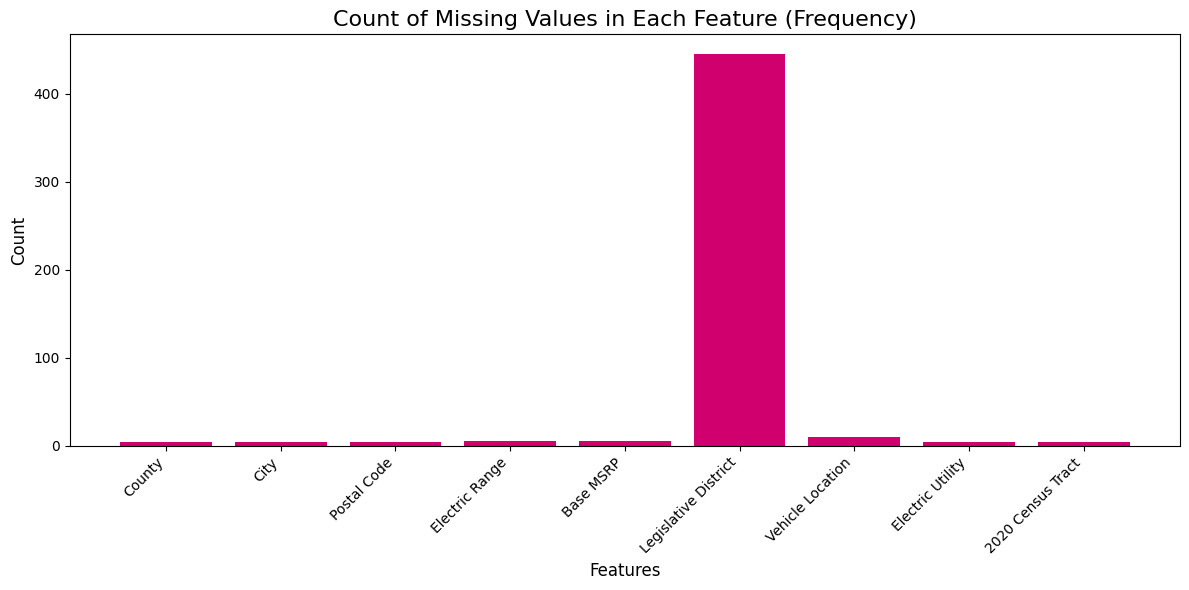

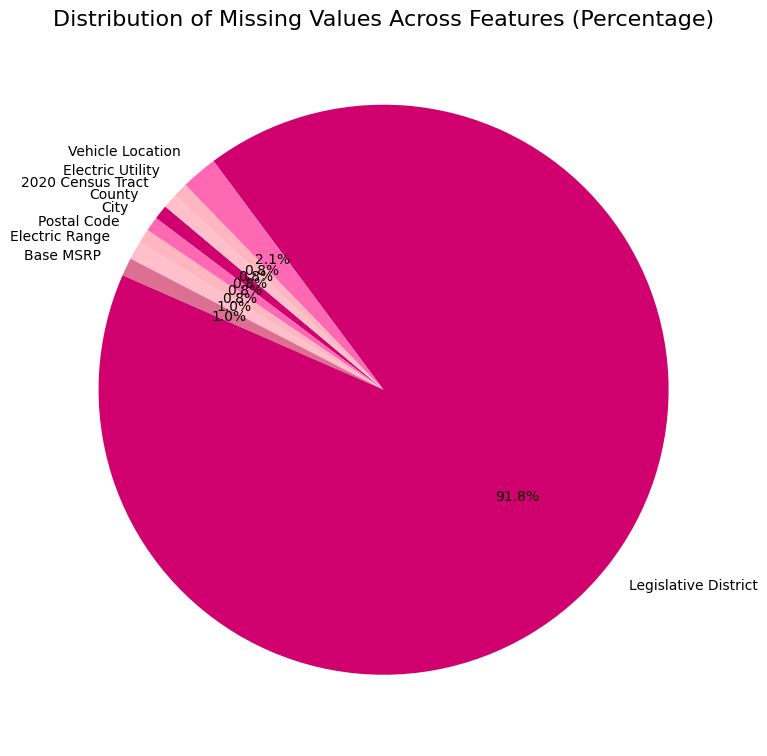

In [3]:
# Check for missing values
missing_data = df.isnull().sum().reset_index()
missing_data.columns = ['Feature', 'Count']
missing_data['Percentage'] = (missing_data['Count'] / len(df)) * 100

print("Missing Data Summary:")
print(missing_data)

missing_data_filtered = missing_data[missing_data['Count'] > 0]

# Bar chart for missing values
plt.figure(figsize=(12, 6))
plt.bar(missing_data_filtered['Feature'], missing_data_filtered['Count'], color='#D0006F')
plt.title("Count of Missing Values in Each Feature (Frequency)", fontsize=16)
plt.xlabel("Features", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Pie chart for missing values percentage
plt.figure(figsize=(8, 8))
colors = ['#D0006F', '#FF69B4', '#FFB6C1', '#FFC0CB', '#DB7093']  # Shades of pink
plt.pie(missing_data_filtered['Count'], labels=missing_data_filtered['Feature'], autopct='%1.1f%%', startangle=140, colors=colors)
plt.title("Distribution of Missing Values Across Features (Percentage)", fontsize=16)
plt.tight_layout()
plt.show()

2. Missing Value Strategies: If missing values are present, apply multiple strategies (e.g., mean/median imputation, dropping rows) and compare their impact on the analysis.

In [4]:
#Fill missing numbers with the Strategy 1 mean 
df_mean_imputed = df.copy()
for column in df_mean_imputed.select_dtypes(include=['float64', 'int64']):
    mean_value = df_mean_imputed[column].mean()
    df_mean_imputed[column] = df_mean_imputed[column].fillna(mean_value)

print("\nMissing Values After Mean Imputation (Numerical Features):")
print(df_mean_imputed.isnull().sum())

# Fill missing numbers with the  Strategy 2 median
df_median_imputed = df.copy()
for column in df_median_imputed.select_dtypes(include=['float64', 'int64']):
    median_value = df_median_imputed[column].median()
    df_median_imputed[column] = df_median_imputed[column].fillna(median_value)

print("\nMissing Values After Median Imputation (Numerical Features):")
print(df_median_imputed.isnull().sum())

# Mode Imputation for categorical features Strategy 3
df_mode_imputed = df.copy()
for column in df_mode_imputed.select_dtypes(include=['object']):
    mode_value = df_mode_imputed[column].mode()[0]
    df_mode_imputed[column] = df_mode_imputed[column].fillna(mode_value)

print("\nMissing Values After Mode Imputation (Categorical Features):")
print(df_mode_imputed.isnull().sum())

# Drop Rows with Missing Values Strategy 4
df_dropped = df.dropna()

print("\nMissing Values After Dropping Rows:")
print(df_dropped.isnull().sum())

# Compare the impact of each strategy
print("\nOriginal Dataset Shape:", df.shape)
print("Dataset Shape After Mean Imputation:", df_mean_imputed.shape)
print("Dataset Shape After Median Imputation:", df_median_imputed.shape)
print("Dataset Shape After Mode Imputation:", df_mode_imputed.shape)
print("Dataset Shape After Dropping Rows:", df_dropped.shape)


Missing Values After Mean Imputation (Numerical Features):
VIN (1-10)                                            0
County                                                4
City                                                  4
State                                                 0
Postal Code                                           0
Model Year                                            0
Make                                                  0
Model                                                 0
Electric Vehicle Type                                 0
Clean Alternative Fuel Vehicle (CAFV) Eligibility     0
Electric Range                                        0
Base MSRP                                             0
Legislative District                                  0
DOL Vehicle ID                                        0
Vehicle Location                                     10
Electric Utility                                      4
2020 Census Tract                           

Fill missing values either by imputation(mean for numerical + mode for categorical) or drop rows (will see impact of them on analysis)

In [5]:
# Strategy 1: Mean and Mode Imputation
df_imputed = df.copy()

# Fill missing numbers with the average
for column in df_imputed.select_dtypes(include=['float64', 'int64']):
    mean_value = df_imputed[column].mean()
    df_imputed[column] = df_imputed[column].fillna(mean_value)  

# Fill missing text with the most common value
for column in df_imputed.select_dtypes(include=['object']):
    mode_value = df_imputed[column].mode()[0]
    df_imputed[column] = df_imputed[column].fillna(mode_value)  


print("\nMissing Values After imputation:")
print(df_imputed.isnull().sum())


# Strategy 2: Remove rows with missing values
df_dropped = df.copy()  
df_dropped = df_dropped.dropna() 

print("\nMissing Values After Dropping Rows:")
print(df_dropped.isnull().sum())

# Compare the size of datasets
print("\nShape of Dataset After Imputation (Mean + Mode):", df_imputed.shape)
print("Shape of Dataset After Dropping Rows:", df_dropped.shape)

df_imputed_copy = df_imputed.copy()
df_dropped_copy = df_dropped.copy()



Missing Values After imputation:
VIN (1-10)                                           0
County                                               0
City                                                 0
State                                                0
Postal Code                                          0
Model Year                                           0
Make                                                 0
Model                                                0
Electric Vehicle Type                                0
Clean Alternative Fuel Vehicle (CAFV) Eligibility    0
Electric Range                                       0
Base MSRP                                            0
Legislative District                                 0
DOL Vehicle ID                                       0
Vehicle Location                                     0
Electric Utility                                     0
2020 Census Tract                                    0
dtype: int64

Missing Values Af

3. Feature Encoding: Encode categorical features (e.g., Make, Model) using techniques like one-hot encoding.

First: imputation strategy

In [6]:
#Get categorical columns from the imputed dataset
categorical_columns = df_imputed.select_dtypes(include=['object']).columns.tolist()

# Define threshold for cardinality
threshold = 50

#Identify low and high cardinality columns in the imputed dataset
low_cardinality_cols = [col for col in categorical_columns if df_imputed[col].nunique() <= threshold]
high_cardinality_cols = [col for col in categorical_columns if df_imputed[col].nunique() > threshold]

print("\nLow Cardinality Columns:", low_cardinality_cols)
print("High Cardinality Columns:", high_cardinality_cols)

# Apply one-hot encoding to low cardinality columns in df_imputed
encoder = OneHotEncoder(sparse_output=True, drop='first')
one_hot_encoded_imputed = encoder.fit_transform(df_imputed[low_cardinality_cols])
one_hot_df_imputed = pd.DataFrame.sparse.from_spmatrix(
    one_hot_encoded_imputed,
    columns=encoder.get_feature_names_out(low_cardinality_cols),
    index=df_imputed.index
)

# Apply label encoding to high-cardinality columns in df_imputed
label_encoders = {col: LabelEncoder().fit(df_imputed[col].astype(str)) for col in high_cardinality_cols}
for col, le in label_encoders.items():
    df_imputed[col] = le.transform(df_imputed[col].astype(str))

# Concatenate the encoded columns with the rest of the data
df_imputed_final = pd.concat([df_imputed.drop(columns=low_cardinality_cols), one_hot_df_imputed], axis=1)

print("\nShape of Encoded Dataset (Mean + Mode Imputed):", df_imputed_final.shape)
print("\nEncoded Dataset (Mean + Mode Imputed) Preview:")
print(df_imputed_final.head())
print(df_imputed_final.dtypes)



Low Cardinality Columns: ['State', 'Make', 'Electric Vehicle Type', 'Clean Alternative Fuel Vehicle (CAFV) Eligibility']
High Cardinality Columns: ['VIN (1-10)', 'County', 'City', 'Model', 'Vehicle Location', 'Electric Utility']

Shape of Encoded Dataset (Mean + Mode Imputed): (210165, 104)

Encoded Dataset (Mean + Mode Imputed) Preview:
   VIN (1-10)  County  City  Postal Code  Model Year  Model  Electric Range  \
0        3754      87   595      98380.0        2021    147            30.0   
1        3875      87   524      98370.0        2018     88           215.0   
2       10664     169    61      98012.0        2016    100            15.0   
3        3903      87    64      98310.0        2018     88           215.0   
4        1781      85   546      98052.0        2019     86           150.0   

   Base MSRP  Legislative District  DOL Vehicle ID  ...  Make_TESLA  \
0        0.0                  35.0       267929112  ...           0   
1        0.0                  23.0       4

Second: Drop rows strategy

In [7]:
# Apply one-hot encoding to low cardinality columns in df_dropped
encoder = OneHotEncoder(sparse_output=True, drop='first')

# Fit and transform the one-hot encoder on df_dropped's low cardinality columns
one_hot_encoded_dropped = encoder.fit_transform(df_dropped[low_cardinality_cols])
one_hot_df_dropped = pd.DataFrame.sparse.from_spmatrix(
    one_hot_encoded_dropped,
    columns=encoder.get_feature_names_out(low_cardinality_cols),
    index=df_dropped.index
)

# Apply label encoding to high-cardinality columns in df_dropped
label_encoders = {col: LabelEncoder().fit(df_dropped[col].astype(str)) for col in high_cardinality_cols}
for col, le in label_encoders.items():
    df_dropped[col] = le.transform(df_dropped[col].astype(str))

# Make sure the indexes match before combining data
df_dropped.reset_index(drop=True, inplace=True)
one_hot_df_dropped.reset_index(drop=True, inplace=True)

#Concatenate the encoded columns with the rest of the data
df_dropped_final = pd.concat([df_dropped.drop(columns=low_cardinality_cols), one_hot_df_dropped], axis=1)

print("\nShape of Encoded Dataset (Dropped Rows):", df_dropped_final.shape)

# Display a preview of the final dataset
print("\nEncoded Dataset (Dropped Rows) Preview:")
print(df_dropped_final.head())
print(df_dropped_final.dtypes)


Shape of Encoded Dataset (Dropped Rows): (209709, 58)

Encoded Dataset (Dropped Rows) Preview:
   VIN (1-10)  County  City  Postal Code  Model Year  Model  Electric Range  \
0        3752      17   371      98380.0        2021    147            30.0   
1        3873      17   329      98370.0        2018     88           215.0   
2       10659      30    35      98012.0        2016    100            15.0   
3        3901      17    37      98310.0        2018     88           215.0   
4        1780      16   346      98052.0        2019     86           150.0   

   Base MSRP  Legislative District  DOL Vehicle ID  ...  Make_TESLA  \
0        0.0                  35.0       267929112  ...           0   
1        0.0                  23.0       475911439  ...         1.0   
2        0.0                   1.0       101971278  ...           0   
3        0.0                  23.0       474363746  ...         1.0   
4        0.0                  45.0       476346482  ...           0   

  

4. Normalization: Normalize numerical features if necessary for chosen analysis methods.

In [8]:
# Get numerical columns to normalize
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Fist: Apply Min-Max Scaling
min_max_scaler = MinMaxScaler()
min_max_scaled = min_max_scaler.fit_transform(df[numerical_columns])

# Convert the result back to data
min_max_scaled_df = pd.DataFrame(min_max_scaled, columns=numerical_columns)
print("Min-Max Scaled Data:")
print(min_max_scaled_df.head())

# Second: Apply Z-Score Normalization
z_score_scaler = StandardScaler()
z_score_scaled = z_score_scaler.fit_transform(df[numerical_columns])

# Convert the result back to data
z_score_scaled_df = pd.DataFrame(z_score_scaled, columns=numerical_columns)
print("\nZ-Score Normalized Data:")
print(z_score_scaled_df.head())

# Third: Apply Custom Scaling 
def scale_by_decimal_scaling(df):
    scaled_df = pd.DataFrame()
    
    for col in df.columns:
        max_value = df[col].abs().max()  
        j = int(np.floor(np.log10(max_value))) + 1 if max_value != 0 else 0 
        
        print(f"Column: {col}, Max Value: {max_value}, j (10^j): {j}")
        
        scaled_df[col] = df[col] / (10**j)  
    
    return scaled_df

# Apply decimal scaling for each numerical column
custom_scaled_df = scale_by_decimal_scaling(df[numerical_columns])

print(f"\nCustom Scaled Data (divided by 10^j for each column):")
print(custom_scaled_df.head())

# Save all normalized data to CSV
min_max_scaled_df.to_csv('min_max_normalization.csv', index=False)
z_score_scaled_df.to_csv('z_score_normalization.csv', index=False)
custom_scaled_df.to_csv('scaling_normalization.csv', index=False)


Min-Max Scaled Data:
   Postal Code  Model Year  Electric Range  Base MSRP  Legislative District  \
0     0.987766    0.846154        0.089021        0.0              0.708333   
1     0.987664    0.730769        0.637982        0.0              0.458333   
2     0.984005    0.653846        0.044510        0.0              0.000000   
3     0.987051    0.730769        0.637982        0.0              0.458333   
4     0.984414    0.769231        0.445104        0.0              0.916667   

   DOL Vehicle ID  2020 Census Tract  
0        0.559050           0.945730  
1        0.993024           0.945730  
2        0.212763           0.946202  
3        0.989794           0.945730  
4        0.993932           0.945693  

Z-Score Normalized Data:
   Postal Code  Model Year  Electric Range  Base MSRP  Legislative District  \
0     0.082518   -0.016279       -0.236881  -0.117289              0.407157   
1     0.078428   -1.019981        1.890216  -0.117289             -0.397760   
2    -0

First: Apply Z-score on drop rows strategy

In [10]:
# Step 1: Extract numerical columns from df_dropped
numerical_columns_dropped = df_dropped.select_dtypes(include=['float64',  'int64']).columns.tolist()

# Initialize StandardScaler for df_dropped_final
z_score_scaler_dropped = StandardScaler()

# Apply Z-Score Normalization to only continuous numerical columns in df_dropped_final
df_dropped[numerical_columns_dropped] = z_score_scaler_dropped.fit_transform(df_dropped[numerical_columns_dropped])

# print the result of normalization
print("\nNormalized Dataset (Dropped Rows Dataset - Continuous Numerical Columns) Preview:")
print(df_dropped[numerical_columns_dropped].head())


Normalized Dataset (Dropped Rows Dataset - Continuous Numerical Columns) Preview:
   Postal Code  Model Year  Electric Range  Base MSRP  Legislative District  \
0     0.369996   -0.016552       -0.236797  -0.117191              0.407127   
1     0.337505   -1.020142        1.890604  -0.117191             -0.397789   
2    -0.825672   -1.689202       -0.409289  -0.117191             -1.873469   
3     0.142559   -1.020142        1.890604  -0.117191             -0.397789   
4    -0.695709   -0.685612        1.143139  -0.117191              1.077890   

   DOL Vehicle ID  2020 Census Tract  
0        0.545747          -0.299420  
1        3.468452          -0.299432  
2       -1.786402           1.285967  
3        3.446703          -0.300098  
4        3.474566          -0.425159  


Second: Apply Z-score on imputation strategy

In [11]:

#Extract numerical columns from df_imputed_final
numerical_columns_imputed = df_imputed.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Initialize StandardScaler for df_imputed_final
z_score_scaler_imputed = StandardScaler()

# Apply Z-Score Normalization to numerical columns in df_imputed_final
df_imputed[numerical_columns_imputed] = z_score_scaler_imputed.fit_transform(df_imputed[numerical_columns_imputed])

# print the result of normalization
print("\nNormalized Dataset (Imputed Dataset) Preview:")
print(df_imputed[numerical_columns_dropped].head())



Normalized Dataset (Imputed Dataset) Preview:
   Postal Code  Model Year  Electric Range  Base MSRP  Legislative District  \
0     0.082518   -0.016279       -0.236884   -0.11729              0.407589   
1     0.078429   -1.019981        1.890238   -0.11729             -0.398182   
2    -0.067968   -1.689116       -0.409353   -0.11729             -1.875429   
3     0.053893   -1.019981        1.890238   -0.11729             -0.398182   
4    -0.051611   -0.685414        1.142871   -0.11729              1.079065   

   DOL Vehicle ID  2020 Census Tract  
0        0.546015           0.035964  
1        3.468961           0.035964  
2       -1.786327           0.052698  
3        3.447210           0.035957  
4        3.475075           0.034637  


Exploratory Data Analysis

5. Descriptive Statistics: Calculate summary statistics (mean, median, standard deviation) for numerical features.

In [12]:
# Calculate summary statistics for imputed dataset
mean_values_imputed = df_imputed[numerical_columns_imputed].mean()
median_values_imputed = df_imputed[numerical_columns_imputed].median()
std_dev_values_imputed = df_imputed[numerical_columns_imputed].std()

# Combine the results into a summary DataFrame for imputed dataset
summary_statistics_imputed = pd.DataFrame({
    'Mean (Imputed)': mean_values_imputed,
    'Median (Imputed)': median_values_imputed,
    'Standard Deviation (Imputed)': std_dev_values_imputed
})

# Calculate summary statistics for dropped rows dataset
mean_values_dropped = df_dropped[numerical_columns_dropped].mean()
median_values_dropped = df_dropped[numerical_columns_dropped].median()
std_dev_values_dropped = df_dropped[numerical_columns_dropped].std()

# Combine the results into a summary DataFrame for dropped rows dataset
summary_statistics_dropped = pd.DataFrame({
    'Mean (Dropped Rows)': mean_values_dropped,
    'Median (Dropped Rows)': median_values_dropped,
    'Standard Deviation (Dropped Rows)': std_dev_values_dropped
})

# Print the summary statistics for both datasets
print("\nDescriptive Statistics (Imputed Dataset):")
print(summary_statistics_imputed)

print("\nDescriptive Statistics (Dropped Rows Dataset):")
print(summary_statistics_dropped)


Descriptive Statistics (Imputed Dataset):
                      Mean (Imputed)  Median (Imputed)  \
Postal Code            -4.104795e-15         -0.021759   
Model Year             -1.736501e-14          0.318288   
Electric Range          5.977397e-17         -0.581822   
Base MSRP              -2.238143e-17         -0.117290   
Legislative District   -4.132788e-16          0.206146   
DOL Vehicle ID          2.894034e-17          0.160761   
2020 Census Tract       4.632077e-15          0.034636   

                      Standard Deviation (Imputed)  
Postal Code                               1.000002  
Model Year                                1.000002  
Electric Range                            1.000002  
Base MSRP                                 1.000002  
Legislative District                      1.000002  
DOL Vehicle ID                            1.000002  
2020 Census Tract                         1.000002  

Descriptive Statistics (Dropped Rows Dataset):
                    

6. Spatial Distribution: Visualize the spatial distribution of EVs across locations (e.g., maps)

First: Spatial distribution on imputation strategy

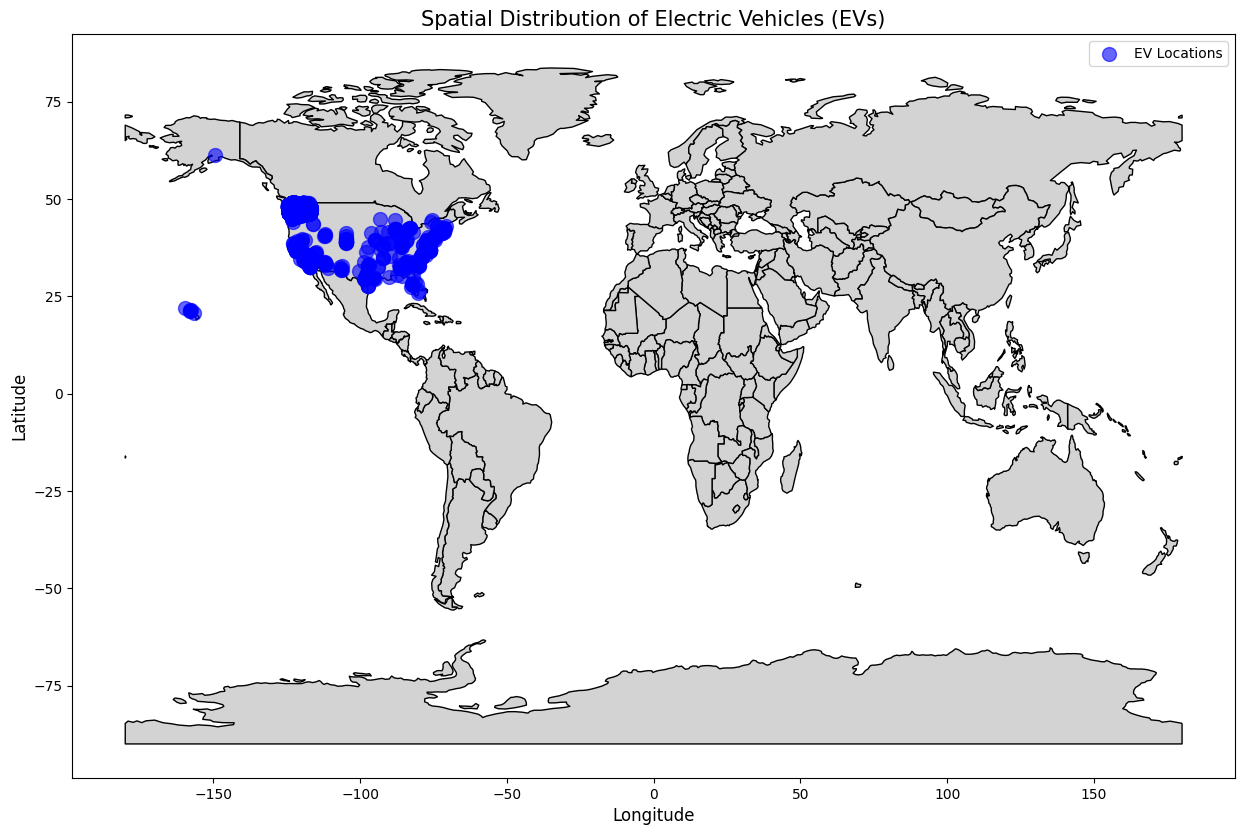

In [13]:


# Ensure 'Vehicle Location' column is treated as string
df_imputed['Vehicle Location'] = df_imputed_copy['Vehicle Location'].astype(str)

# Function to extract longitude and latitude
def extract_coordinates(loc):
    match = re.search(r'POINT \((-?\d+\.\d+) (-?\d+\.\d+)\)', loc)
    if match:
        return float(match.group(1)), float(match.group(2))
    return None, None  # Return None if no match

# Apply the coordinate extraction function and create Longitude and Latitude columns
df_imputed[['Longitude', 'Latitude']] = df_imputed['Vehicle Location'].apply(lambda loc: pd.Series(extract_coordinates(loc)))


# Check if there are valid coordinates left for plotting
if df_imputed.empty:
    raise ValueError("No valid coordinates found for plotting.")

# Create a GeoDataFrame using extracted coordinates
gdf = gpd.GeoDataFrame(
    df_imputed,
    geometry=gpd.points_from_xy(df_imputed['Longitude'], df_imputed['Latitude']),
    crs="EPSG:4326"  # WGS84 coordinate reference system
)

# Check if there are valid geometries
if gdf.geometry.is_empty.sum() > 0:
    raise ValueError("Some geometries in the GeoDataFrame are invalid.")

# Load the world map from GeoPandas datasets
world = gpd.read_file('spatial/ne_110m_admin_0_countries.shp')

# Create a plot for spatial distribution
fig, ax = plt.subplots(figsize=(15, 10))


world.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plot the EV locations from the GeoDataFrame
gdf.plot(ax=ax, color='blue', markersize=100, alpha=0.6, label='EV Locations')


ax.set_title('Spatial Distribution of Electric Vehicles (EVs)', fontsize=15)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)


plt.legend()
plt.show()


Second: Spatial distribution on drop rows strategy

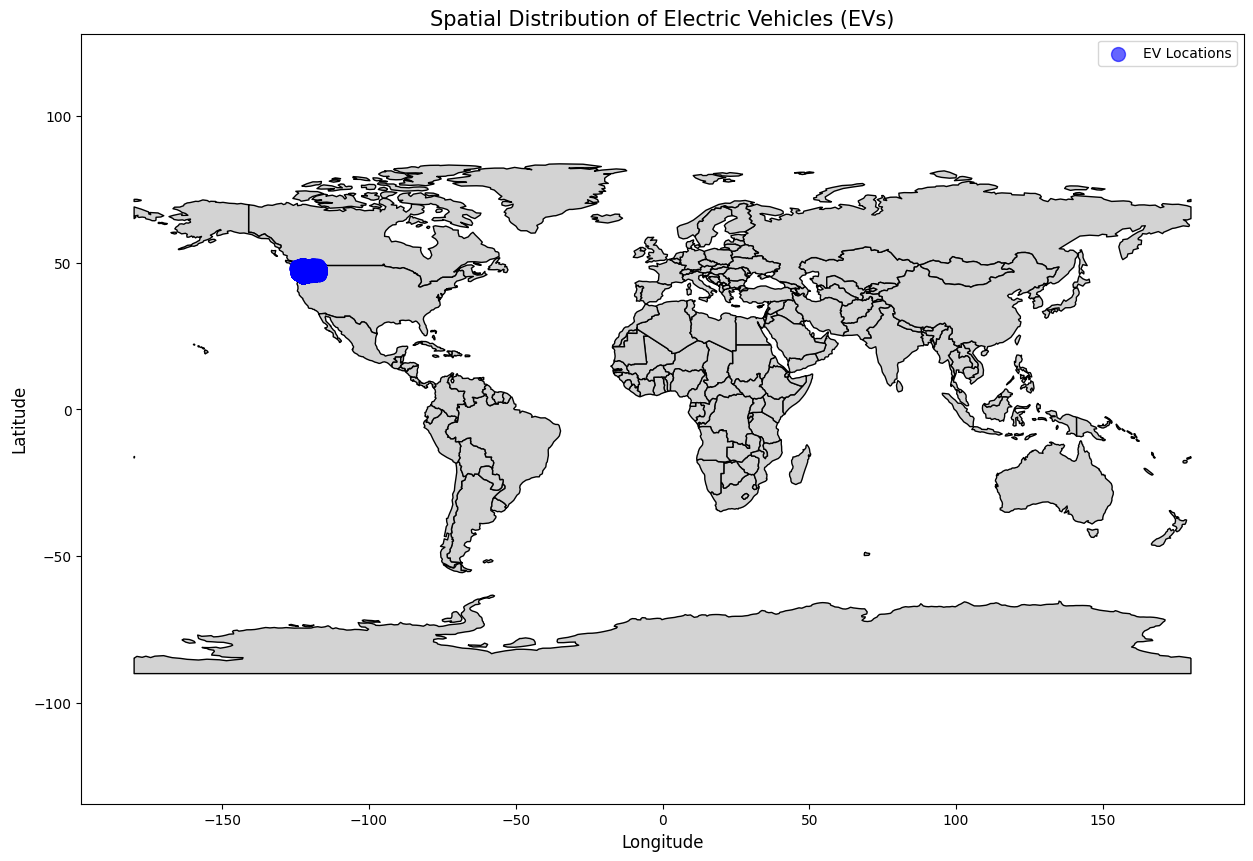

In [14]:

# Ensure 'Vehicle Location' column is treated as string
df_dropped['Vehicle Location'] = df_dropped_copy['Vehicle Location'].astype(str)

# Extract coordinates from 'Vehicle Location' and create a GeoDataFrame
df_dropped['Longitude'] = df_dropped['Vehicle Location'].apply(
    lambda loc: float(re.search(r'POINT \((-?\d+\.\d+) (-?\d+\.\d+)\)', loc).group(1)) 
    if isinstance(loc, str) and re.search(r'POINT \((-?\d+\.\d+) (-?\d+\.\d+)\)', loc) else None
)

df_dropped['Latitude'] = df_dropped['Vehicle Location'].apply(
    lambda loc: float(re.search(r'POINT \((-?\d+\.\d+) (-?\d+\.\d+)\)', loc).group(2)) 
    if isinstance(loc, str) and re.search(r'POINT \((-?\d+\.\d+) (-?\d+\.\d+)\)', loc) else None
)

# Create a GeoDataFrame using extracted coordinates
gdf = gpd.GeoDataFrame(
    df_dropped,
    geometry=gpd.points_from_xy(df_dropped['Longitude'], df_dropped['Latitude']),
    crs="EPSG:4326"  # WGS84 coordinate reference system
)

# Remove any invalid geometries
gdf = gdf[gdf.geometry.is_valid]

# Check if the GeoDataFrame is empty
if gdf.empty:
    print("GeoDataFrame is empty. Check the input data for valid coordinates.")
else:
    # Load the world map from GeoPandas datasets
    world = gpd.read_file('spatial/ne_110m_admin_0_countries.shp')

    # Create a plot for spatial distribution
    fig, ax = plt.subplots(figsize=(15, 10))

    world.plot(ax=ax, color='lightgrey', edgecolor='black')

    gdf.plot(ax=ax, color='blue', markersize=100, alpha=0.6, label='EV Locations')

    ax.set_title('Spatial Distribution of Electric Vehicles (EVs)', fontsize=15)
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)

    # Set a fixed aspect ratio
    ax.set_aspect('equal', adjustable='datalim')

    plt.legend()
    plt.show()


7. Model Popularity: Analyze the popularity of different EV models (categorical data) and identify any trends.

First: Model Popularity on drop rows strategy


Model Counts (Dropped Rows Dataset):
Model
MODEL Y           43937
MODEL 3           32432
LEAF              13596
MODEL S            7774
BOLT EV            6770
                  ...  
750E                  2
745LE                 2
PROMASTER 3500        2
918                   1
VF 8                  1
Name: count, Length: 153, dtype: int64

Top 10 models (Dropped Rows Dataset):
Model
MODEL Y           43937
MODEL 3           32432
LEAF              13596
MODEL S            7774
BOLT EV            6770
MODEL X            6227
VOLT               4805
ID.4               4705
MUSTANG MACH-E     4354
WRANGLER           4102
Name: count, dtype: int64


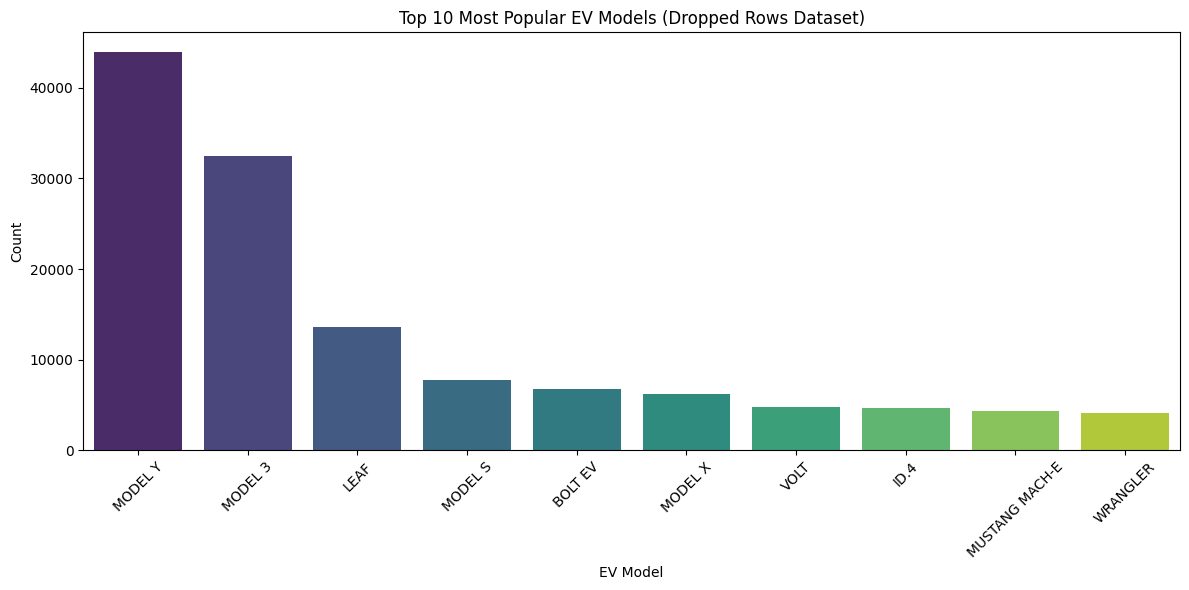

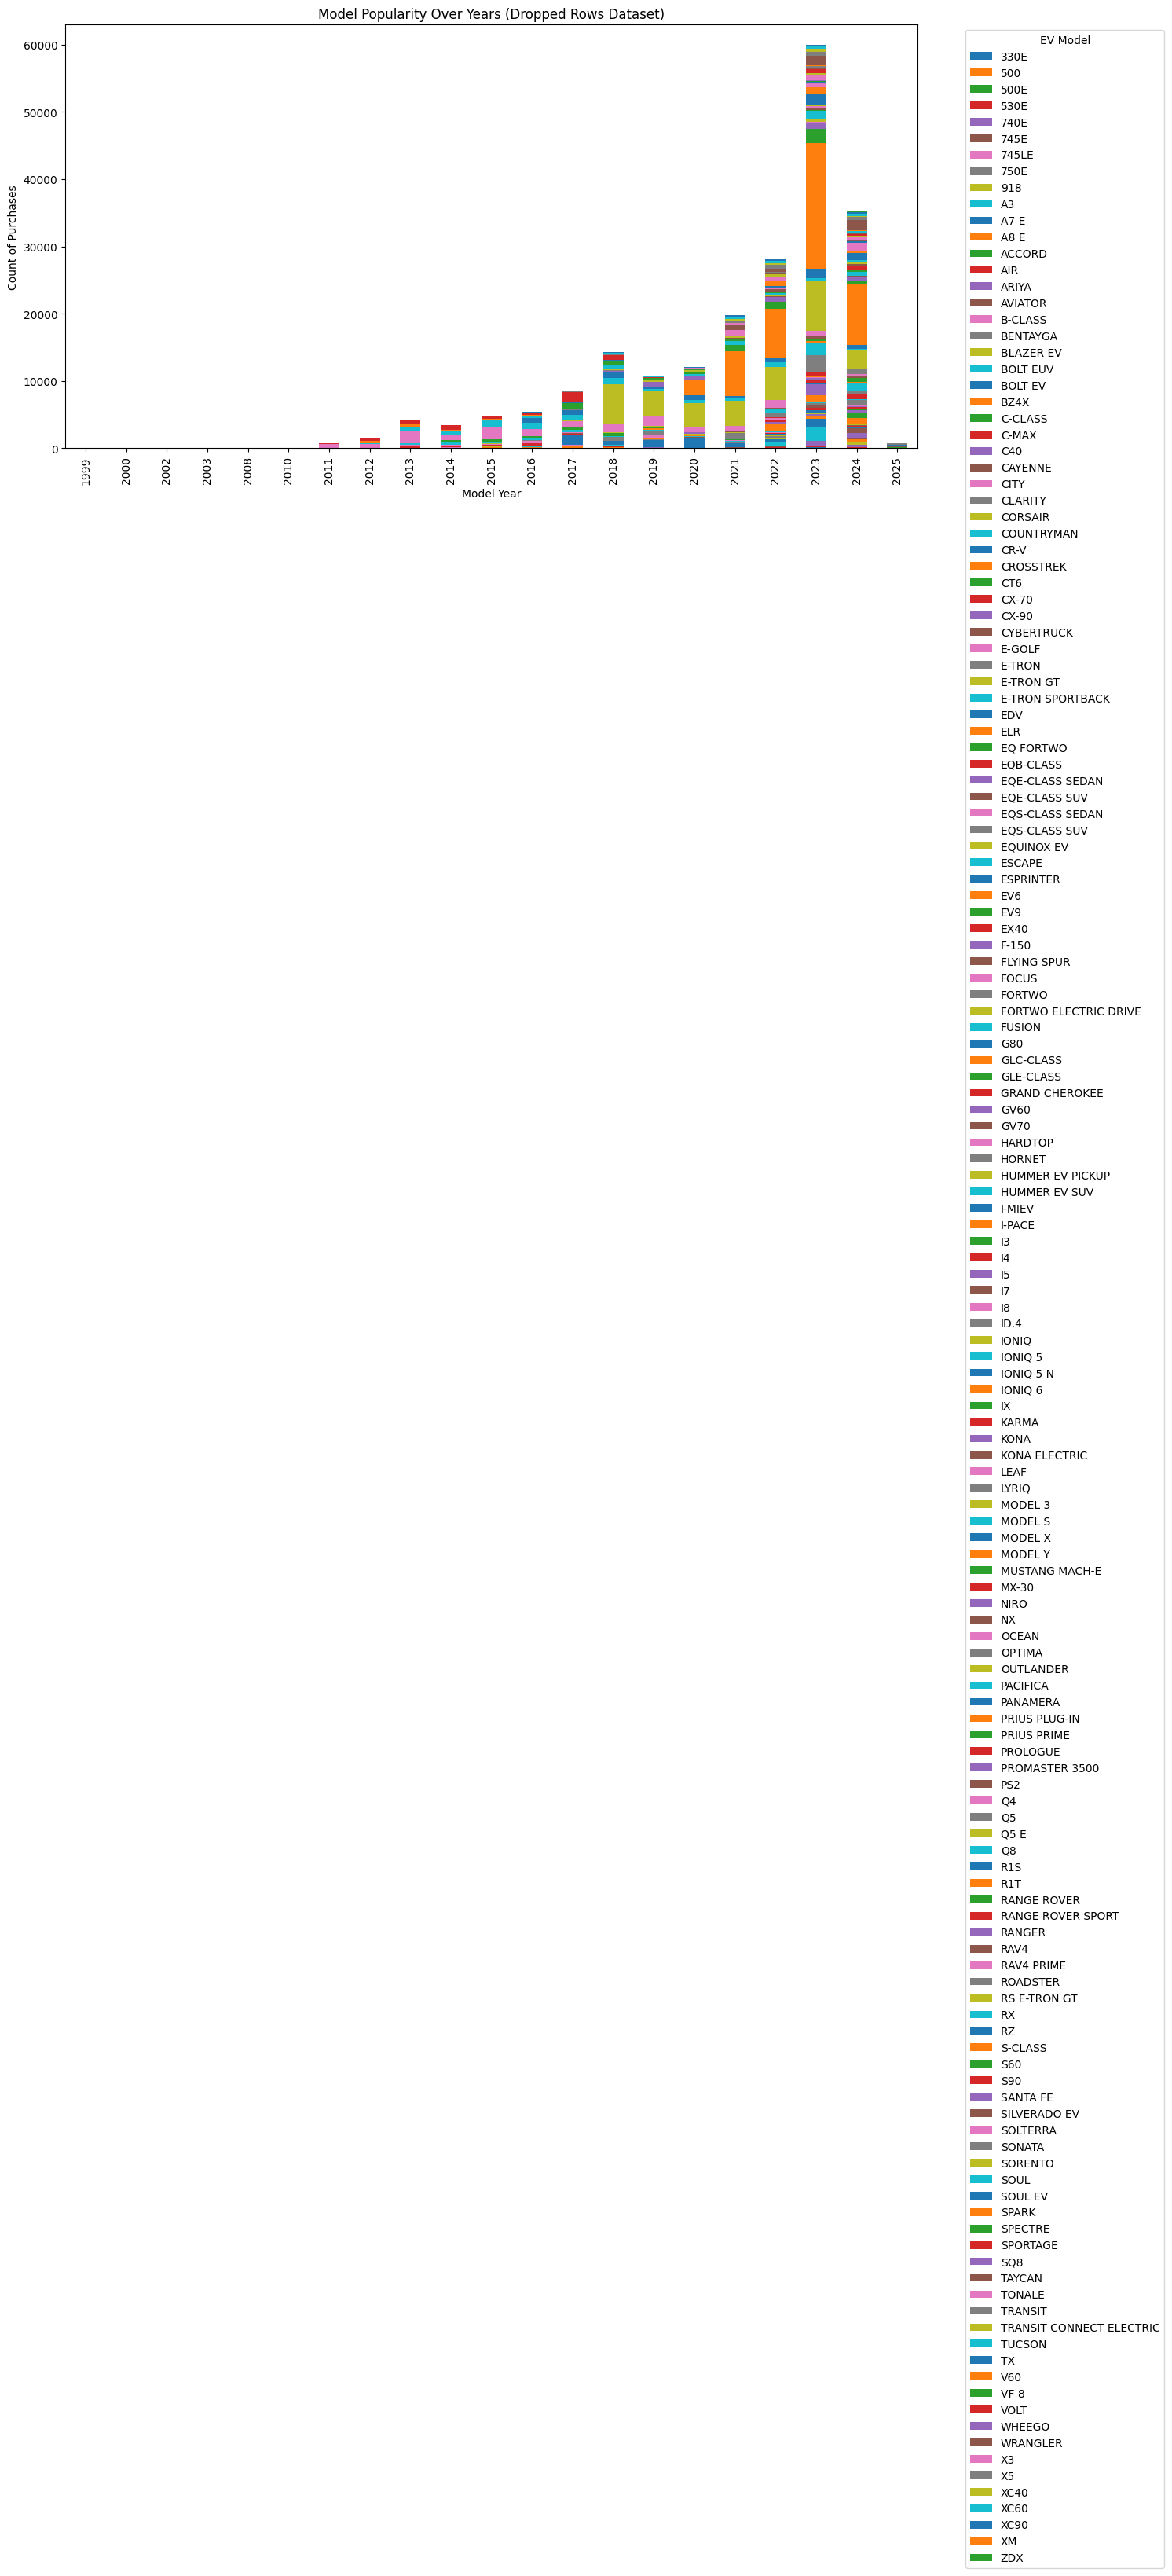

Model  330E  500  500E  530E  740E  745E  745LE  750E  918   A3  ...  VOLT  \
State                                                            ...         
WA      503  780    23   432    29    12      2     2    1  567  ...  4805   

Model  WHEEGO  WRANGLER   X3    X5  XC40  XC60  XC90  XM  ZDX  
State                                                          
WA          3      4102  330  2583  1169  1369  1762  14   61  

[1 rows x 153 columns]
State CA not found in the dataset.


In [15]:
# Count occurrences of each EV model
model_counts_dropped = df_dropped_copy['Model'].value_counts()
print("\nModel Counts (Dropped Rows Dataset):")
print(model_counts_dropped)

# Get the top 10 models for visualization
top_n_dropped = model_counts_dropped.nlargest(10)
print("\nTop 10 models (Dropped Rows Dataset):")
print(top_n_dropped)

# Create the bar plot for top models
plt.figure(figsize=(12, 6))
sns.barplot(x=top_n_dropped.index, y=top_n_dropped.values, hue=top_n_dropped.index, palette='viridis', legend=False)
plt.title('Top 10 Most Popular EV Models (Dropped Rows Dataset)')
plt.xlabel('EV Model')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Analyzing Model Popularity Over Time
if 'Model Year' in df_dropped_copy.columns:
    # Group by model and year
    model_year_counts_dropped = df_dropped_copy.groupby(['Model Year', 'Model']).size().unstack(fill_value=0)

    # Plot the trends
    plt.figure(figsize=(14, 7))
    model_year_counts_dropped.plot(kind='bar', stacked=True, ax=plt.gca())
    plt.title('Model Popularity Over Years (Dropped Rows Dataset)')
    plt.xlabel('Model Year')
    plt.ylabel('Count of Purchases')
    plt.legend(title='EV Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    # plt.tight_layout()
    plt.show()

# Count occurrences of each EV model by state
model_state_counts_dropped = df_dropped_copy.groupby('State')['Model'].value_counts().unstack(fill_value=0)
print(model_state_counts_dropped)


# Plot the top 10 models for a specific state (California)
state = 'CA'
if state in model_state_counts_dropped.index:
    plt.figure(figsize=(12, 6))
    model_state_counts_dropped.loc[state].nlargest(10).plot(kind='bar', color='orange')
    plt.title(f'Top 10 EV Models in {state} (Dropped Rows Dataset)')
    plt.xlabel('EV Model')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print(f"State {state} not found in the dataset.")


Second: Model Popularity on imputation strategy


Model Counts (Imputed Dataset):
Model
MODEL Y           44038
MODEL 3           32520
LEAF              13606
MODEL S            7795
BOLT EV            6780
                  ...  
750E                  2
745LE                 2
PROMASTER 3500        2
918                   1
VF 8                  1
Name: count, Length: 153, dtype: int64

Top 10 models (Imputed Dataset):
Model
MODEL Y           44038
MODEL 3           32520
LEAF              13606
MODEL S            7795
BOLT EV            6780
MODEL X            6239
VOLT               4815
ID.4               4716
MUSTANG MACH-E     4363
WRANGLER           4116
Name: count, dtype: int64


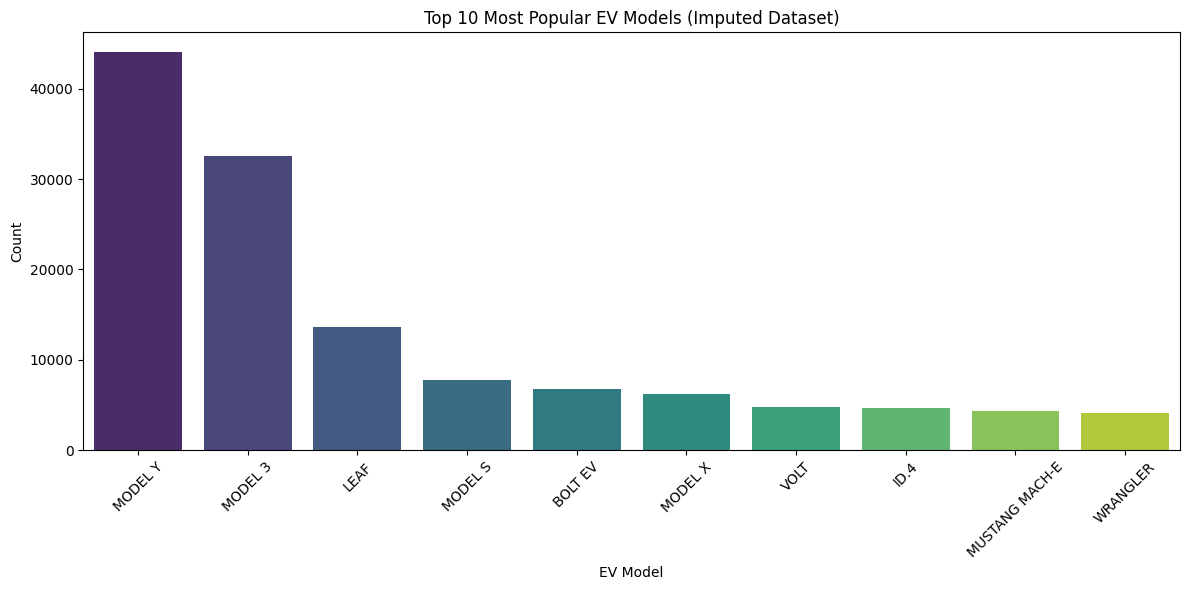

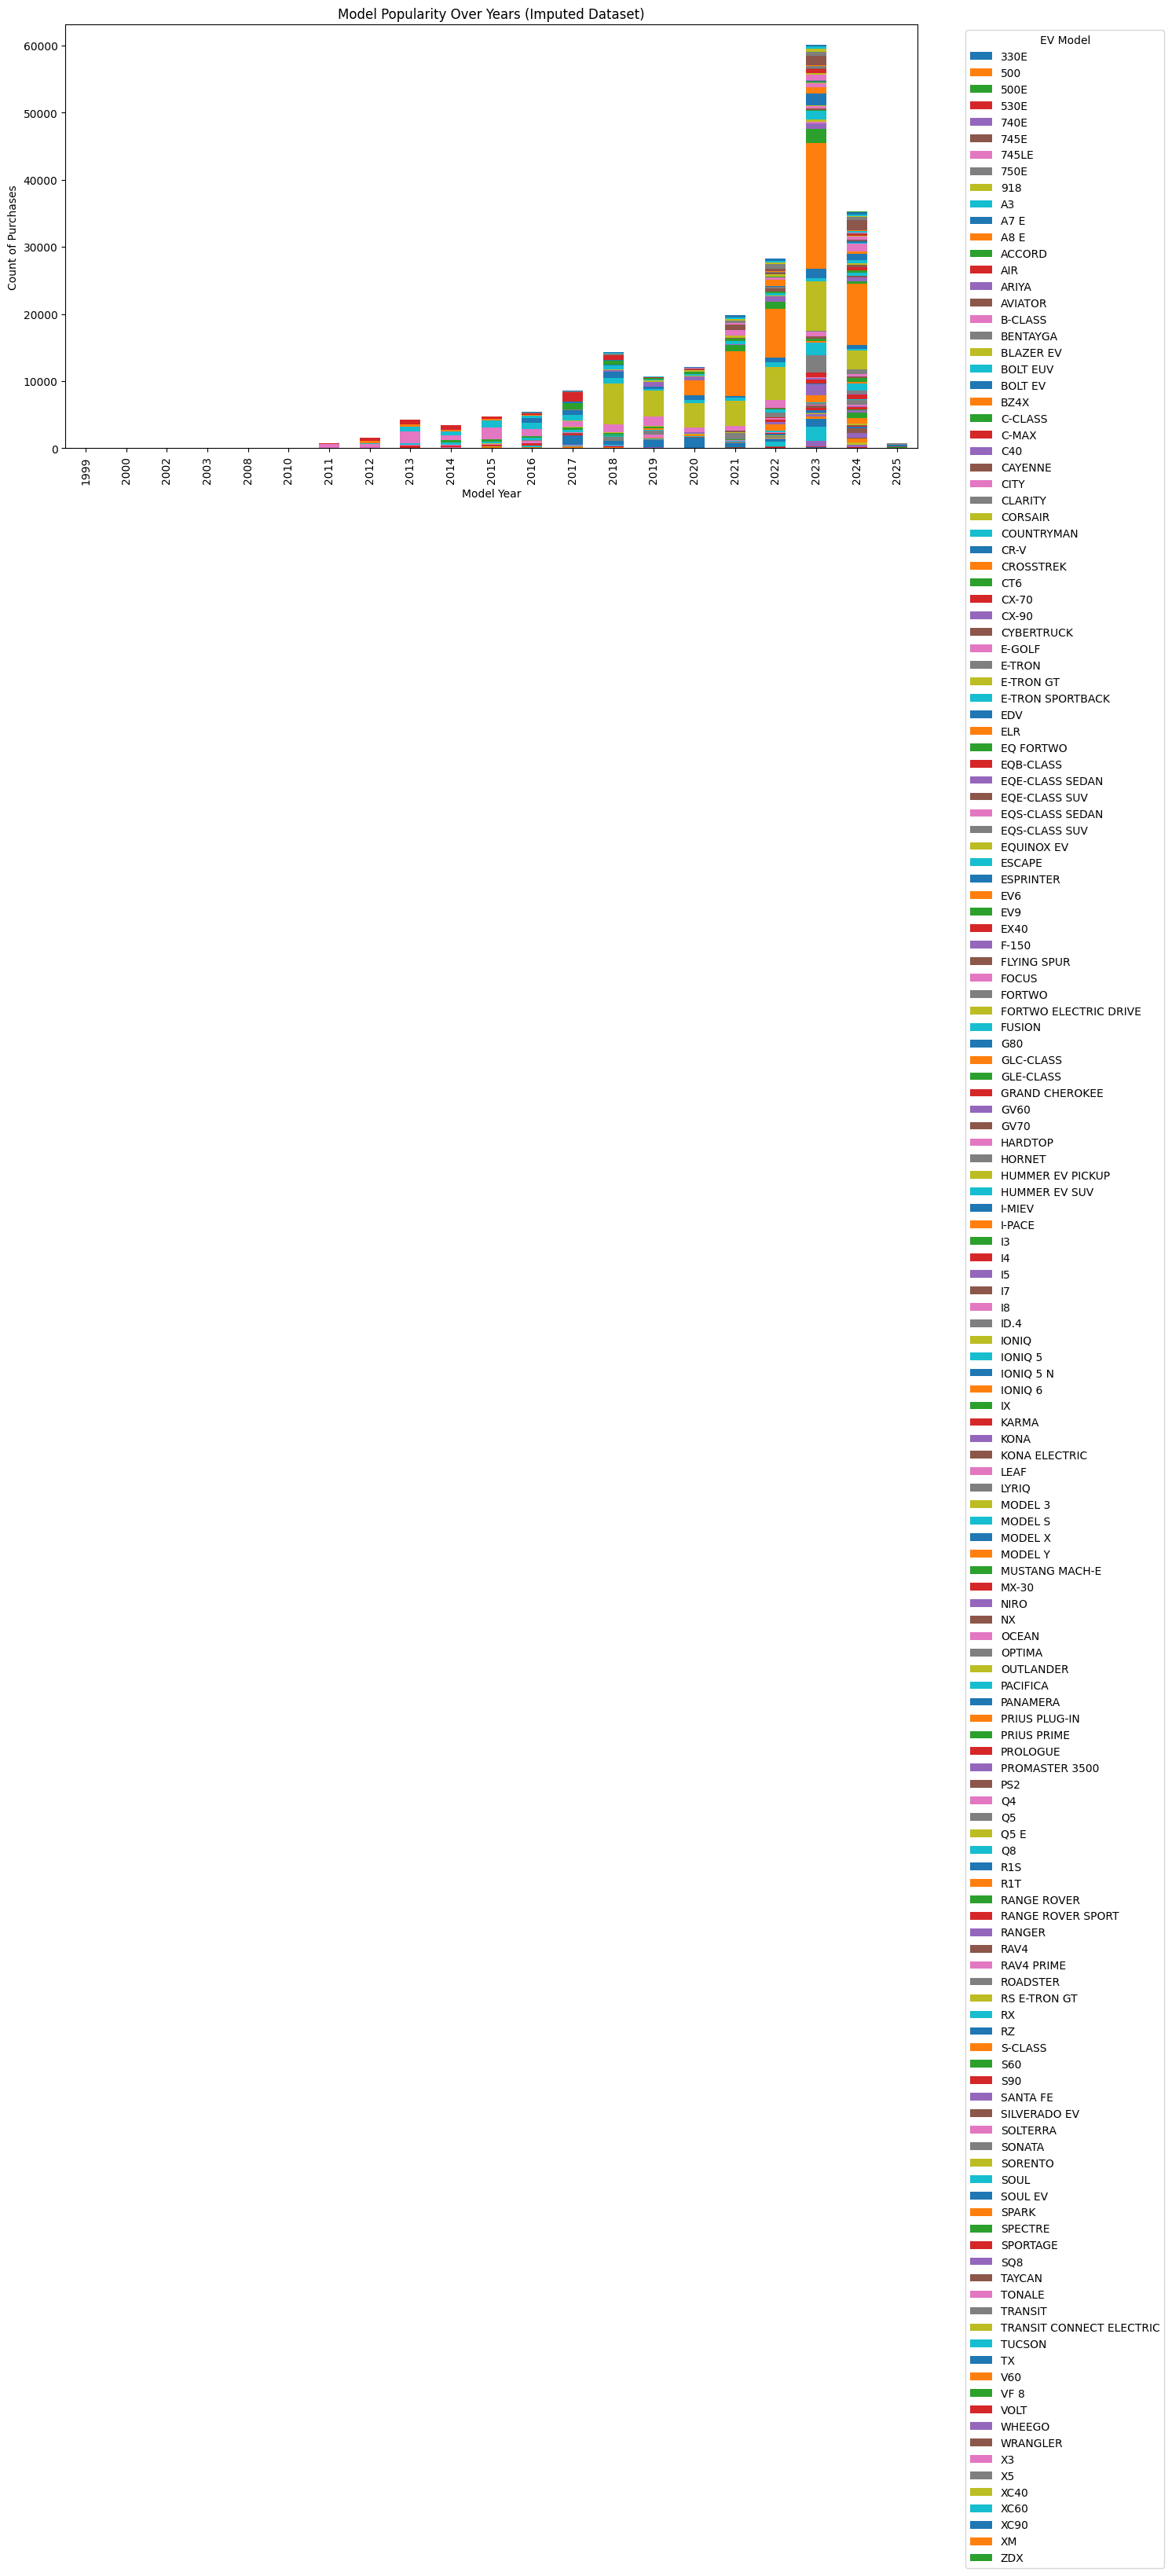

Model  330E  500  500E  530E  740E  745E  745LE  750E  918   A3  ...  VOLT  \
State                                                            ...         
AE        0    0     0     1     0     0      0     0    0    0  ...     0   
AK        0    0     0     0     0     0      0     0    0    0  ...     0   
AL        0    0     0     0     0     0      0     0    0    0  ...     0   
AR        0    0     0     0     0     0      0     0    0    0  ...     0   
AZ        0    0     0     0     0     0      0     0    0    0  ...     0   
BC        0    0     0     0     0     0      0     0    0    0  ...     1   
CA        1    0     0     0     0     0      0     0    0    0  ...     0   
CO        1    0     0     0     0     0      0     0    0    0  ...     0   
CT        0    0     0     0     0     0      0     0    0    0  ...     1   
DC        0    0     0     0     0     0      0     0    0    0  ...     0   
DE        0    0     0     0     0     0      0     0    0    0 

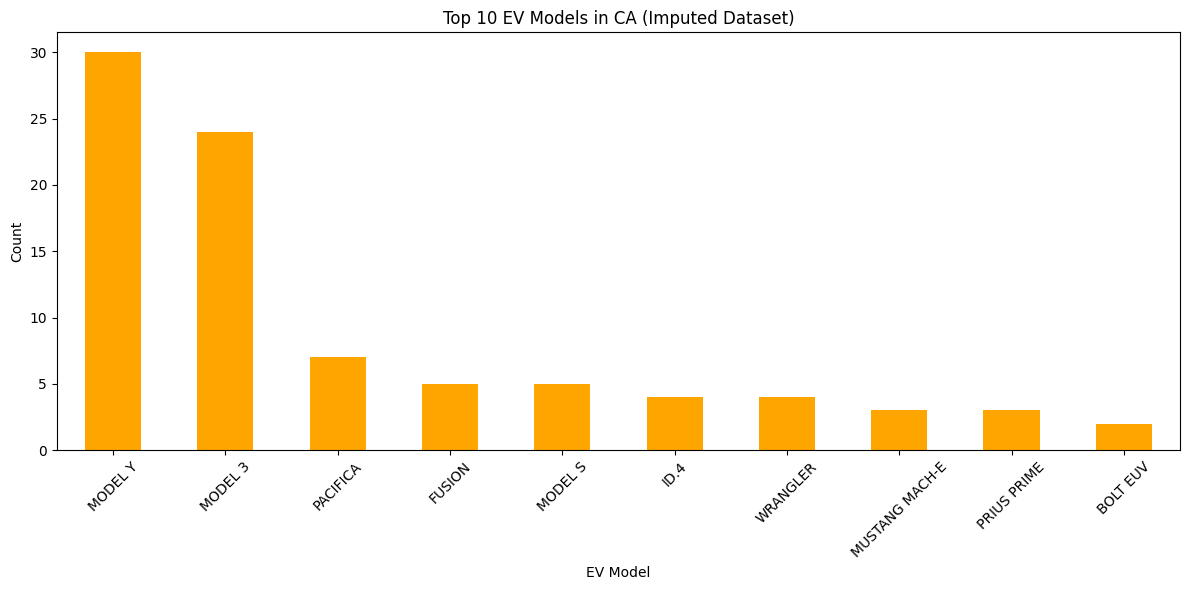

In [16]:
# Count occurrences of each EV model
model_counts_imputed = df_imputed_copy['Model'].value_counts()
print("\nModel Counts (Imputed Dataset):")
print(model_counts_imputed)

# Get the top 10 models for visualization
top_n_imputed = model_counts_imputed.nlargest(10)
print("\nTop 10 models (Imputed Dataset):")
print(top_n_imputed)

# Create the bar plot for top models
plt.figure(figsize=(12, 6))
sns.barplot(x=top_n_imputed.index, y=top_n_imputed.values, hue=top_n_imputed.index, palette='viridis', legend=False)
plt.title('Top 10 Most Popular EV Models (Imputed Dataset)')
plt.xlabel('EV Model')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Analyzing Model Popularity Over Time
if 'Model Year' in df_imputed_copy.columns:
    # Group by model and year
    model_year_counts_imputed = df_imputed_copy.groupby(['Model Year', 'Model']).size().unstack(fill_value=0)

    plt.figure(figsize=(14, 7))
    model_year_counts_imputed.plot(kind='bar', stacked=True, ax=plt.gca())
    plt.title('Model Popularity Over Years (Imputed Dataset)')
    plt.xlabel('Model Year')
    plt.ylabel('Count of Purchases')
    plt.legend(title='EV Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    # plt.tight_layout()
    plt.show()

# Count occurrences of each EV model by state
model_state_counts_imputed = df_imputed_copy.groupby('State')['Model'].value_counts().unstack(fill_value=0)
print(model_state_counts_imputed)


# Plot the top 10 models for a specific state (California)
state = 'CA'
if state in model_state_counts_imputed.index:
    plt.figure(figsize=(12, 6))
    model_state_counts_imputed.loc[state].nlargest(10).plot(kind='bar', color='orange')
    plt.title(f'Top 10 EV Models in {state} (Imputed Dataset)')
    plt.xlabel('EV Model')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print(f"State {state} not found in the dataset.")


8. Investigate the relationship between every pair of numeric features. Are there any correlations? Explain the results.

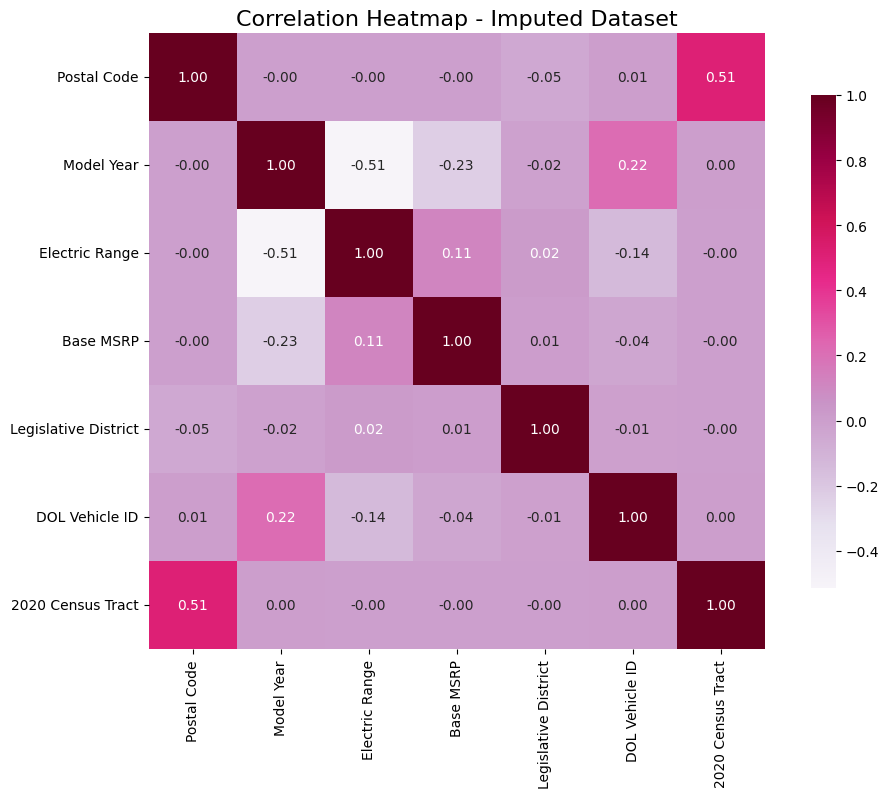

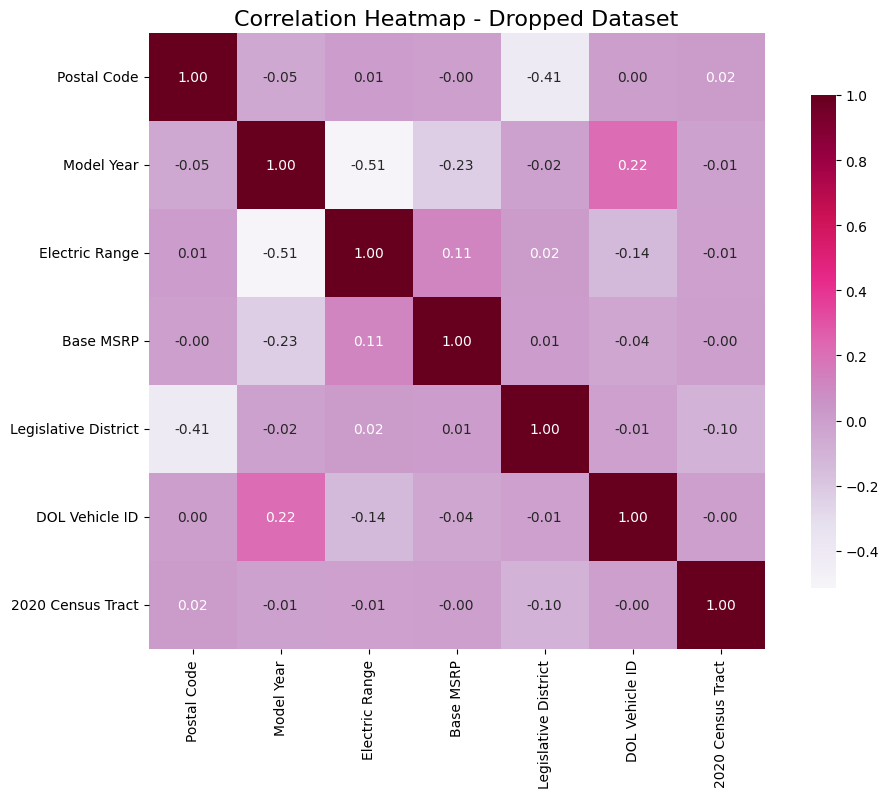

In [17]:
numeric_imputed = df_imputed_copy.select_dtypes(include=['float64', 'int64'])

# Calculate correlation only for numeric columns
correlation_imputed = numeric_imputed.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_imputed, annot=True, fmt=".2f", cmap='PuRd', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap - Imputed Dataset', fontsize=16)
plt.show()

# Strategy 2: Correlation Matrix for Dropped dataset
# Select only numeric columns
numeric_dropped = df_dropped_copy.select_dtypes(include=['float64', 'int64'])

# Calculate correlation only for numeric columns
correlation_dropped = numeric_dropped.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_dropped, annot=True, fmt=".2f", cmap='PuRd', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap - Dropped Dataset', fontsize=16)
plt.show()

Visualization

9. Data Exploration Visualizations: Create various visualizations (e.g., histograms, scatter plots, boxplots) to explore the relationships between features.

First: visualization on imputation dataset

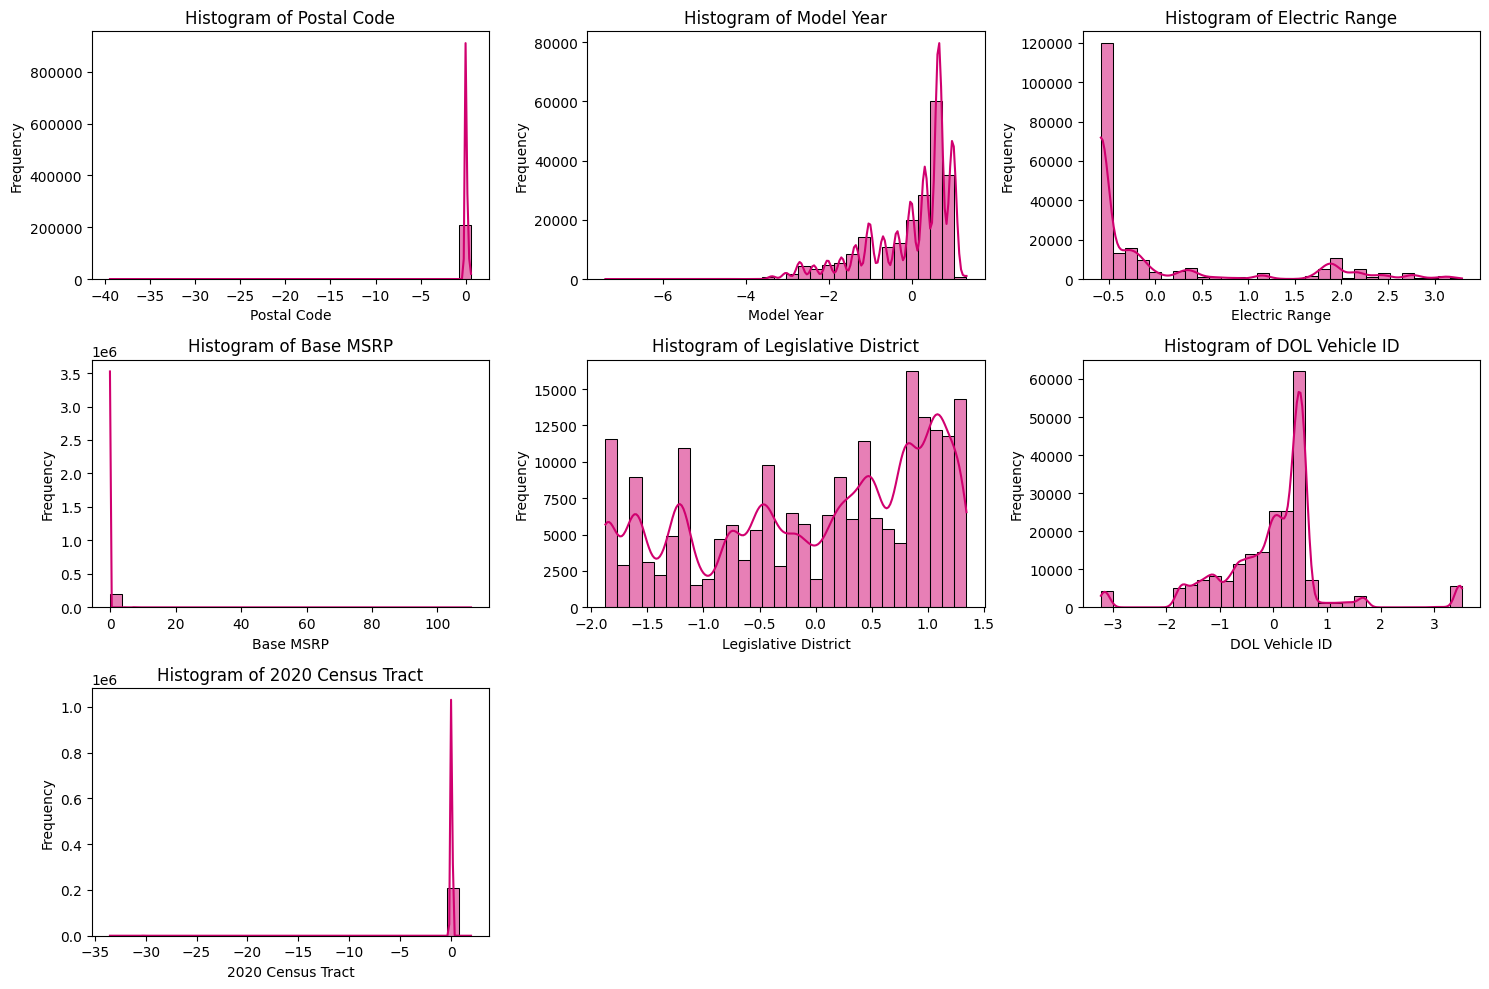

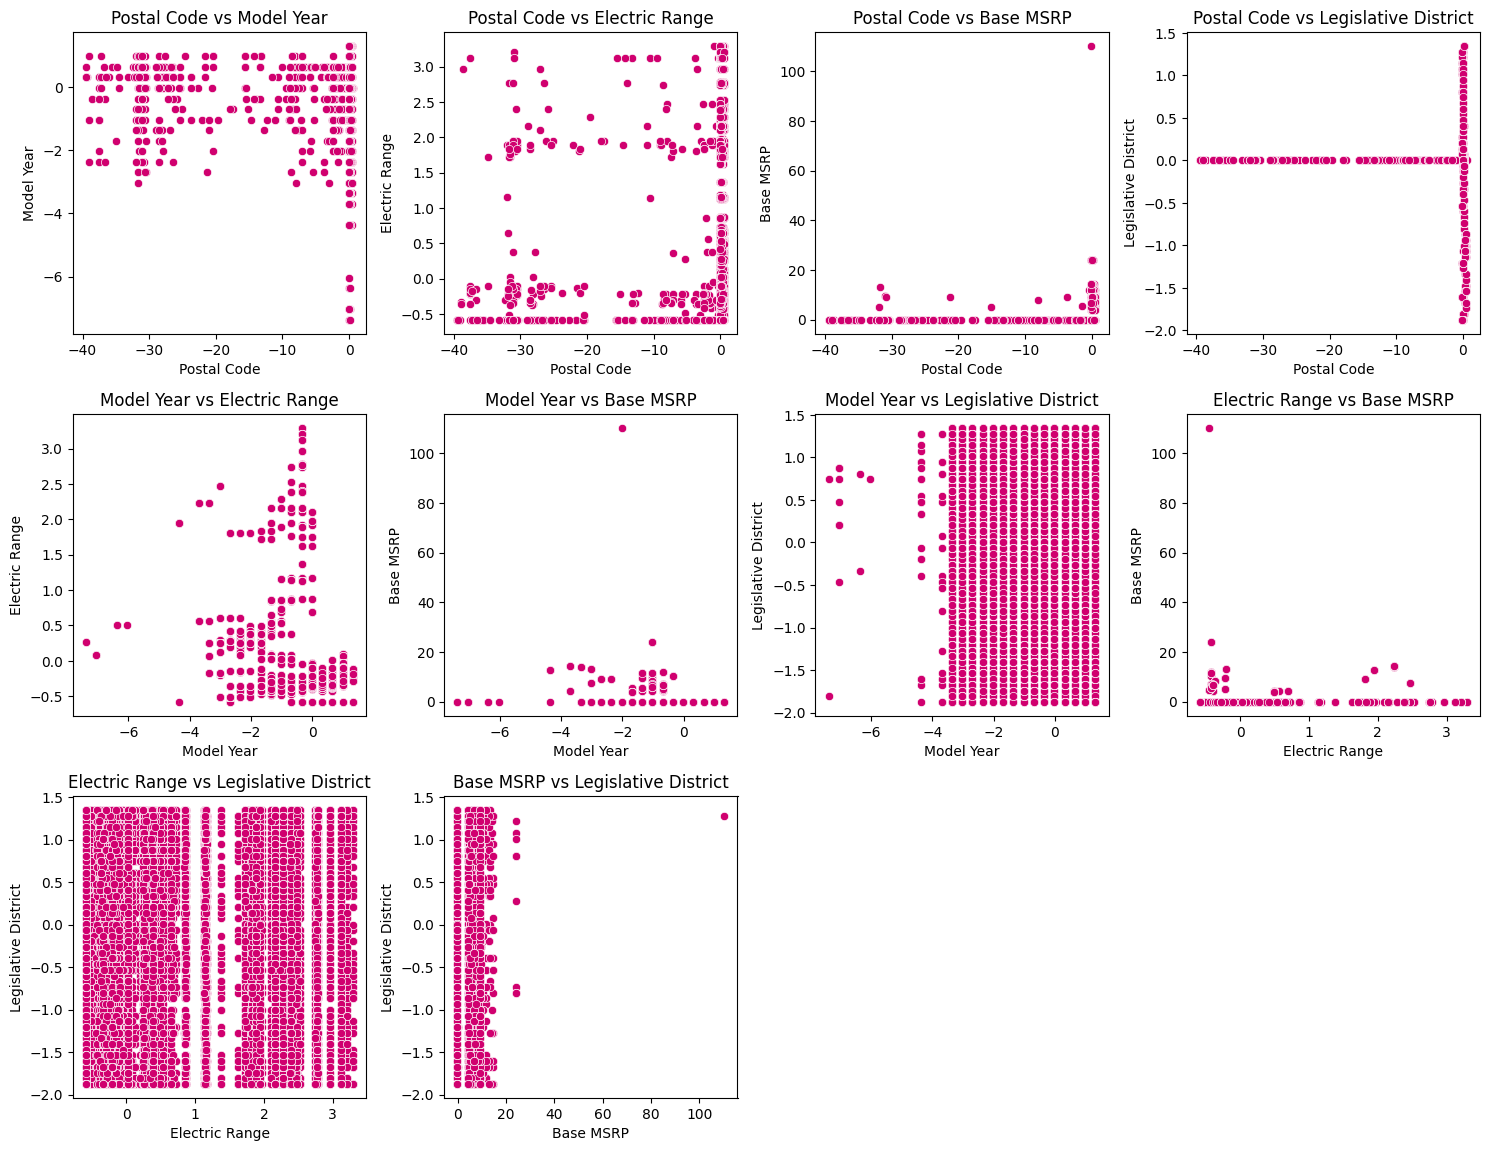

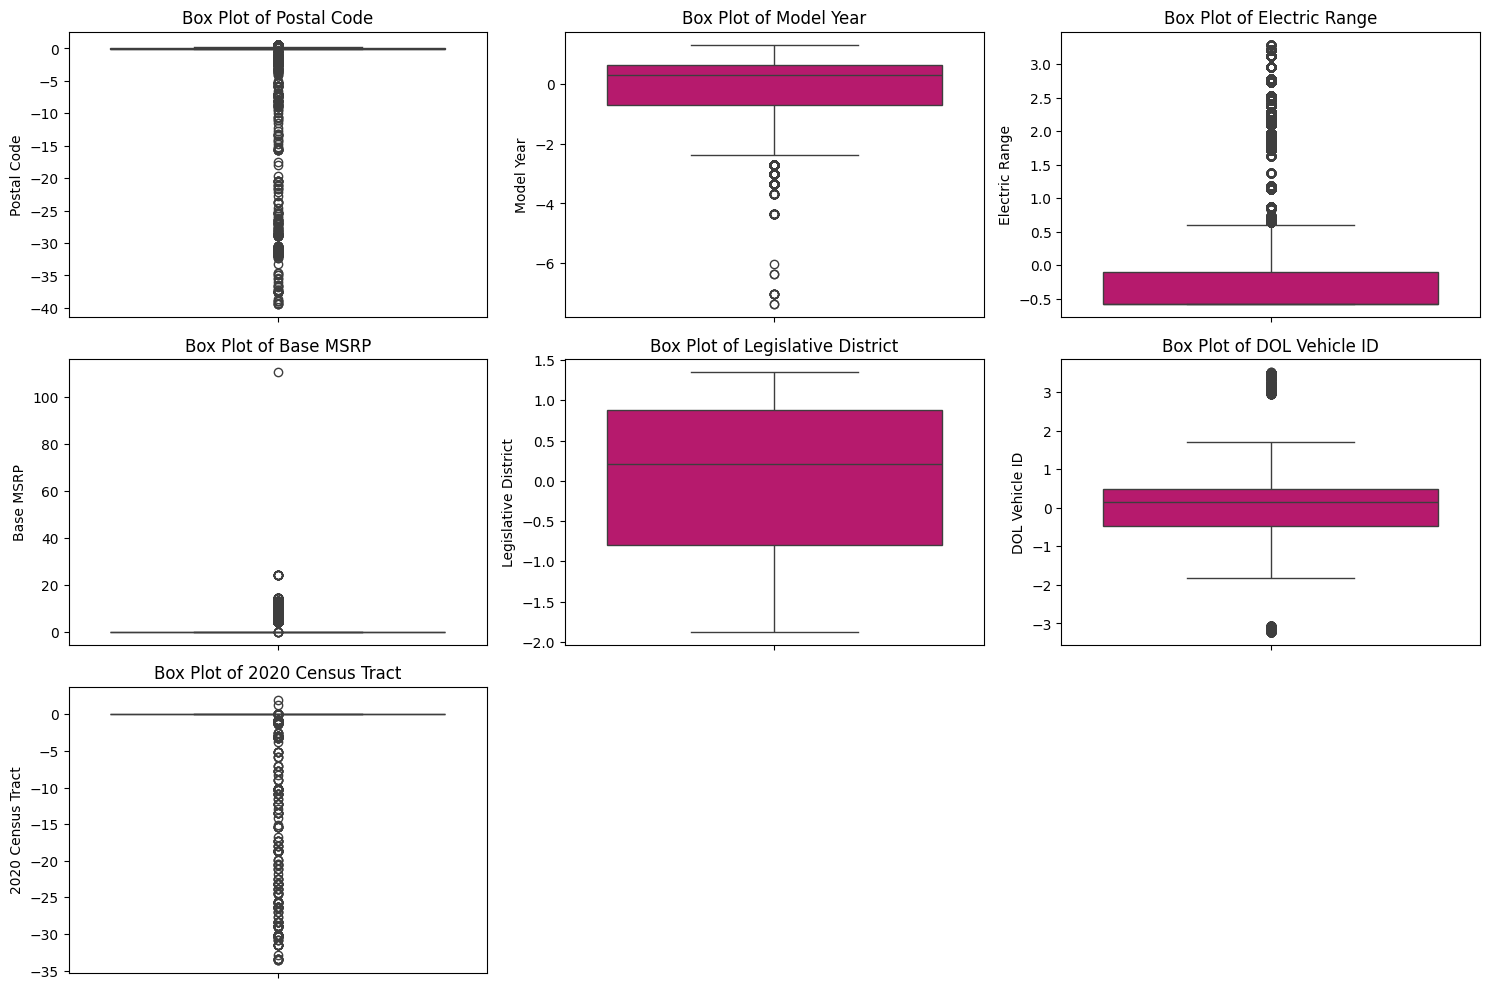

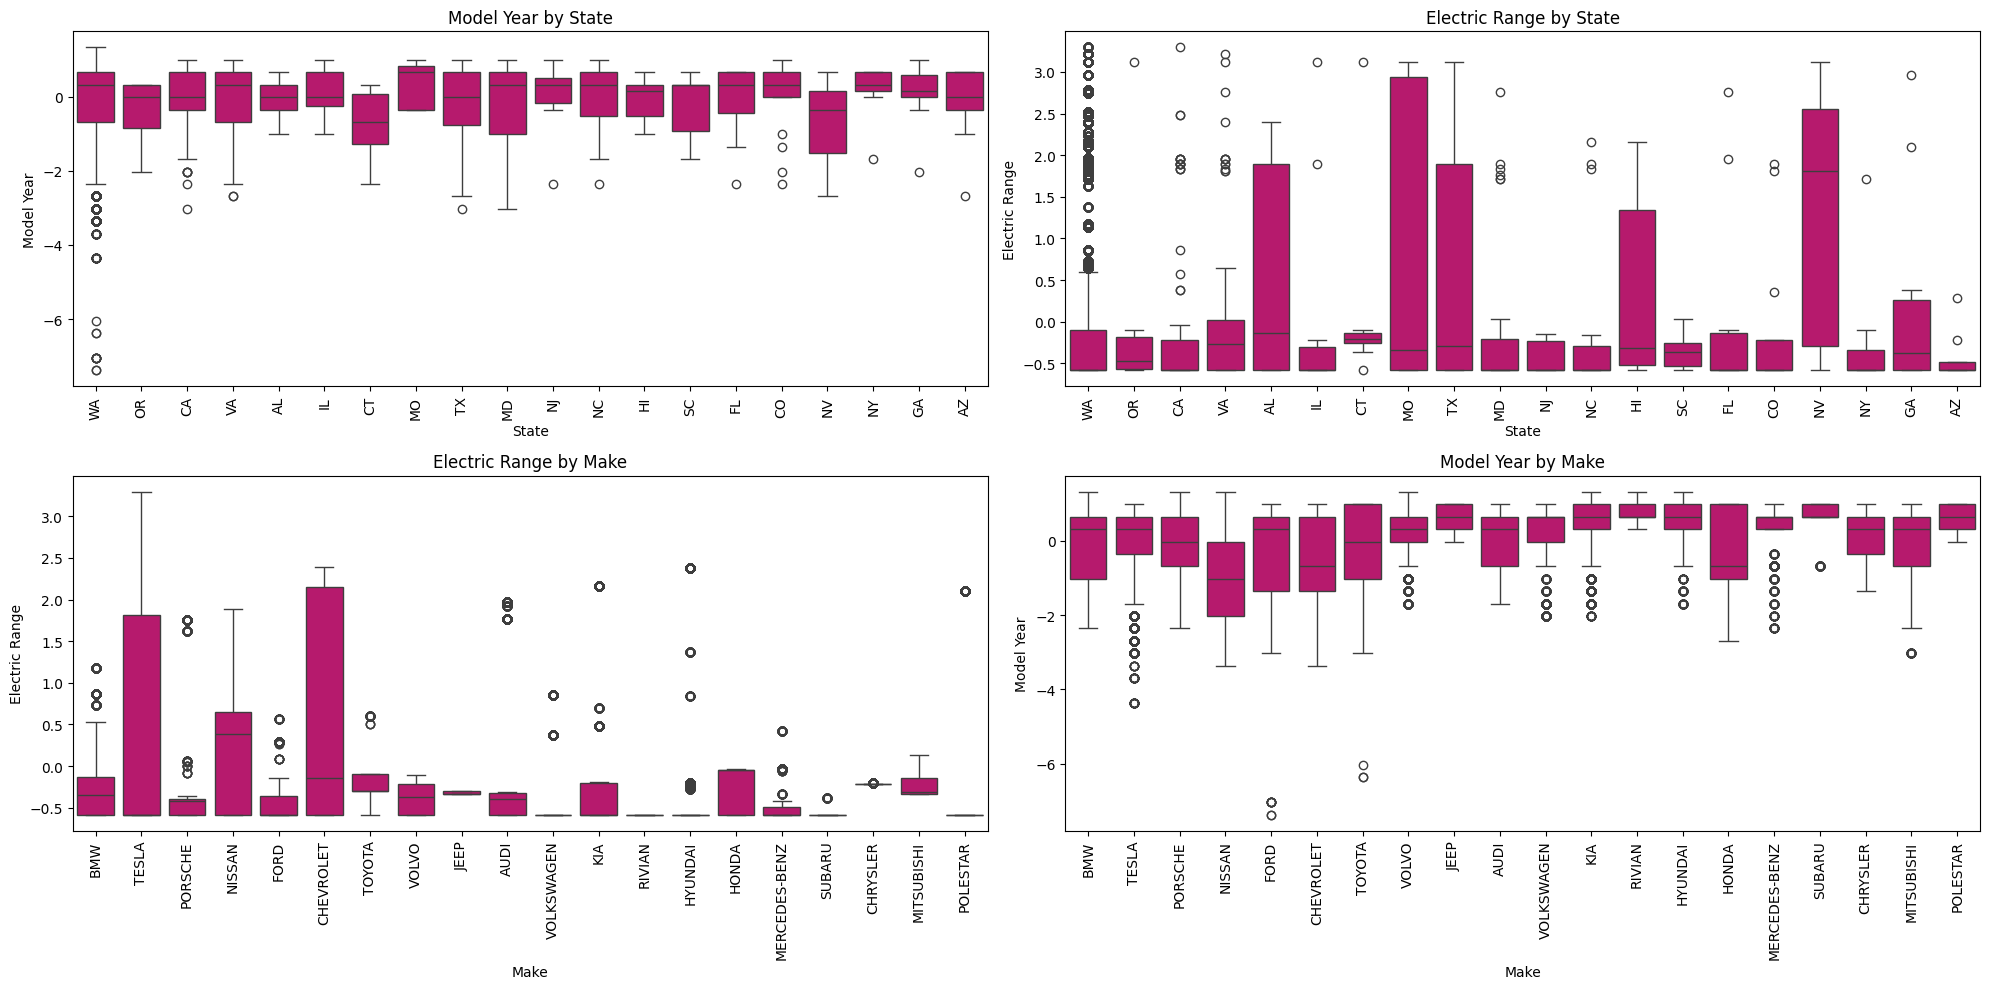

In [18]:
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

dark_pink = "#D0006F"

numerical_columns = numerical_columns_imputed
limited_numerical_columns = numerical_columns[:5]  

# Histograms for each numerical feature
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_columns):
    plt.subplot(3, 3, i + 1)
    sns.histplot(df_imputed[feature], bins=30, kde=True, color=dark_pink)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Scatter plots for each pair of selected numerical features
plt.figure(figsize=(15, 15))
num_features = len(limited_numerical_columns)
for index, (feature1, feature2) in enumerate(itertools.combinations(limited_numerical_columns, 2)):
    plt.subplot(num_features - 1, num_features - 1, index + 1)
    sns.scatterplot(data=df_imputed, x=feature1, y=feature2, color=dark_pink)
    plt.title(f'{feature1} vs {feature2}')
    plt.xlabel(feature1)
    plt.ylabel(feature2)
plt.tight_layout()
plt.show()

# Box plots for each numerical feature individually
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_columns):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(data=df_imputed, y=feature, color=dark_pink)
    plt.title(f'Box Plot of {feature}')
    plt.ylabel(feature)
plt.tight_layout()
plt.show()


selected_pairs = [
    ('State', 'Model Year'),
    ('State', 'Electric Range'),
    ('Make', 'Electric Range'),
    ('Make', 'Model Year')
]

fig, axes = plt.subplots(2, 2, figsize=(20, 10)) 
axes = axes.flatten()  

for plot_index, (cat_feature, num_feature) in enumerate(selected_pairs):
    if cat_feature in df_imputed.columns and num_feature in df_imputed.columns:
        if df_imputed[cat_feature].nunique() > 20:
            df_sampled = df_imputed[df_imputed[cat_feature].isin(df_imputed[cat_feature].value_counts().index[:20])]
        else:
            df_sampled = df_imputed

        sns.boxplot(data=df_sampled, x=cat_feature, y=num_feature, ax=axes[plot_index], color=dark_pink)
        axes[plot_index].set_xlabel(cat_feature)
        axes[plot_index].set_ylabel(num_feature)
        axes[plot_index].set_title(f'{num_feature} by {cat_feature}')
        axes[plot_index].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

Second visualization on dropped dataset

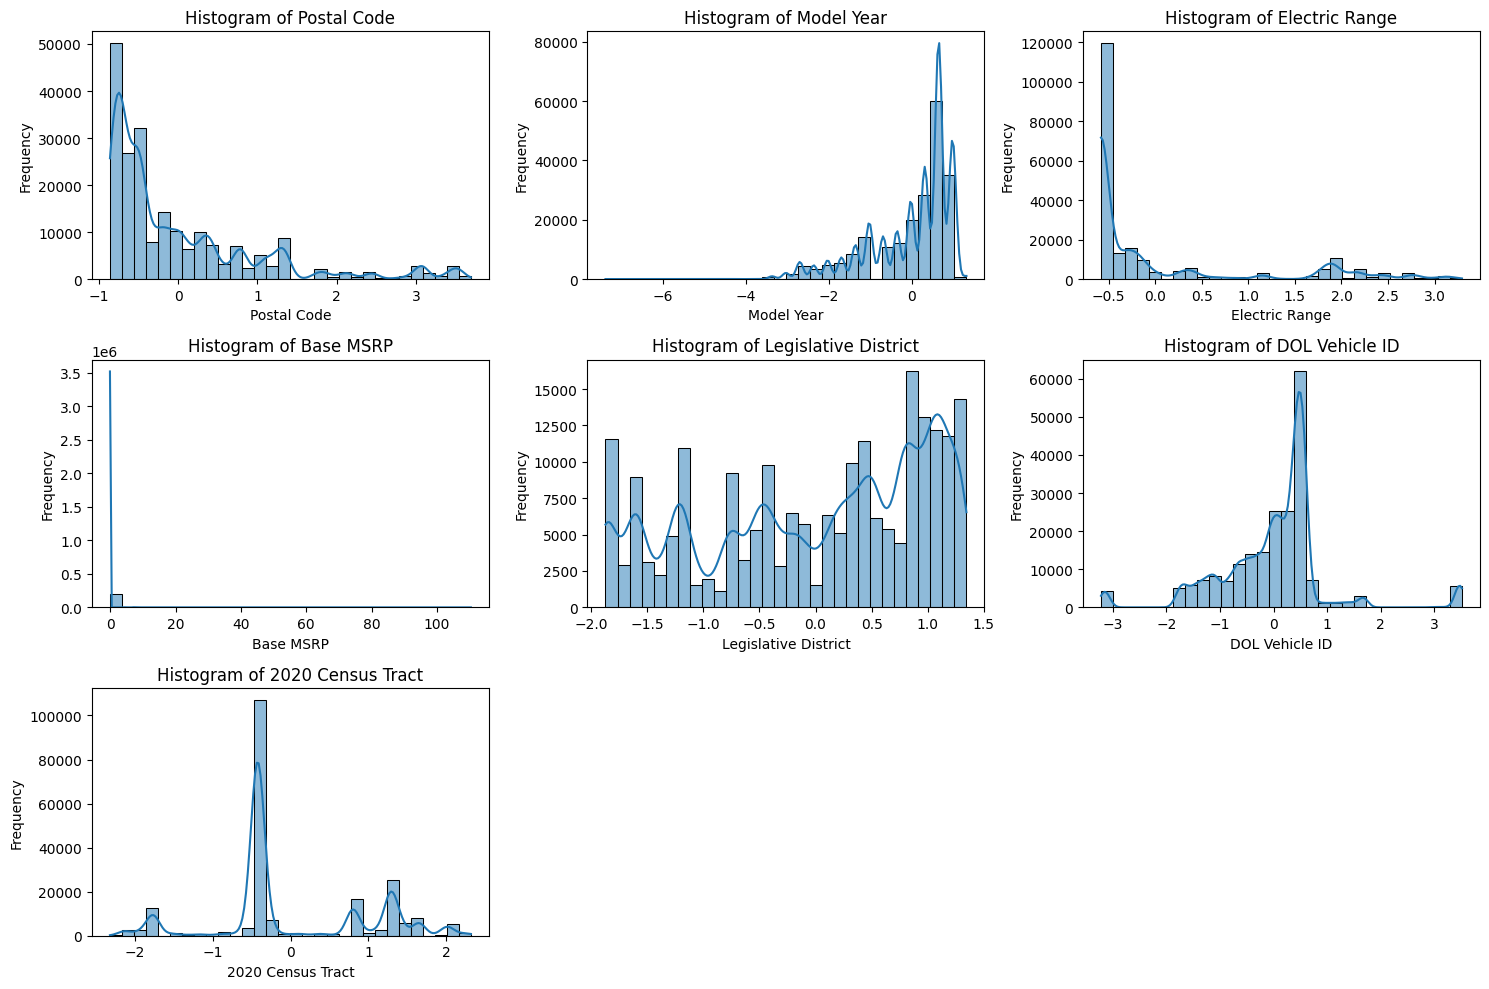

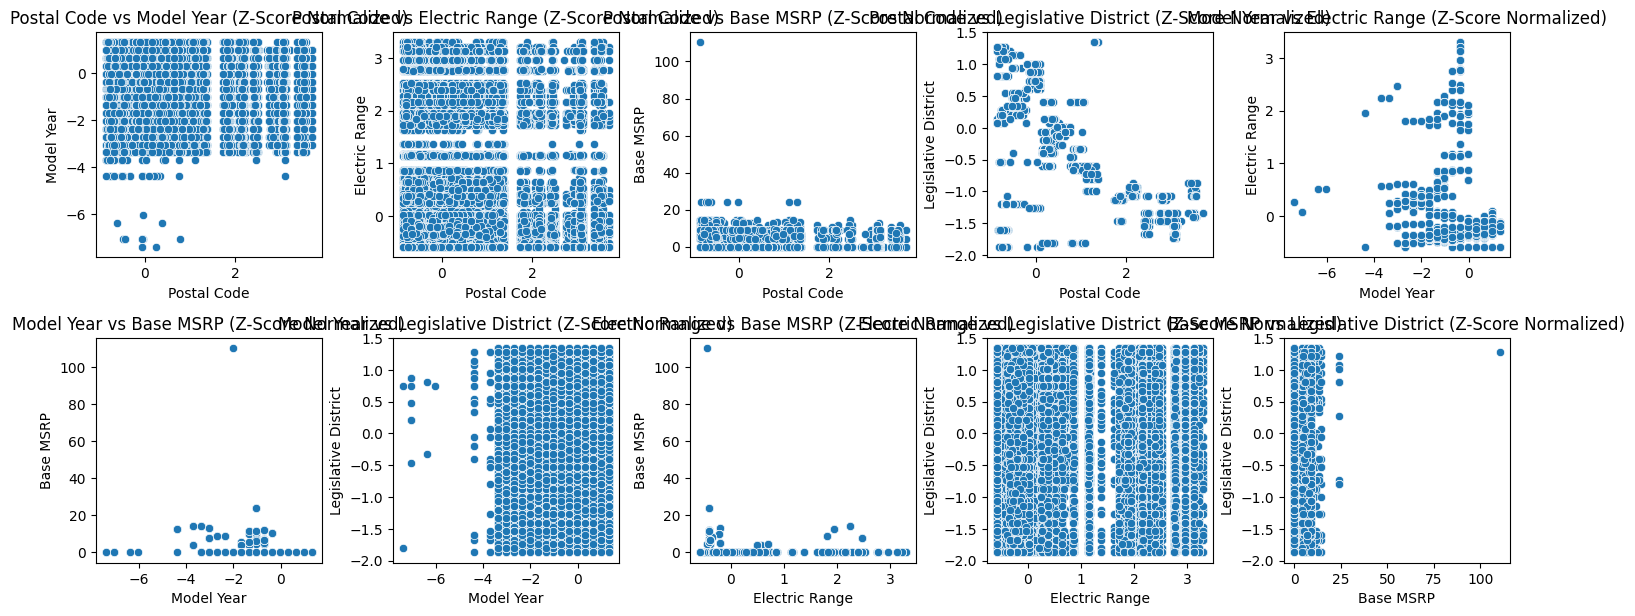

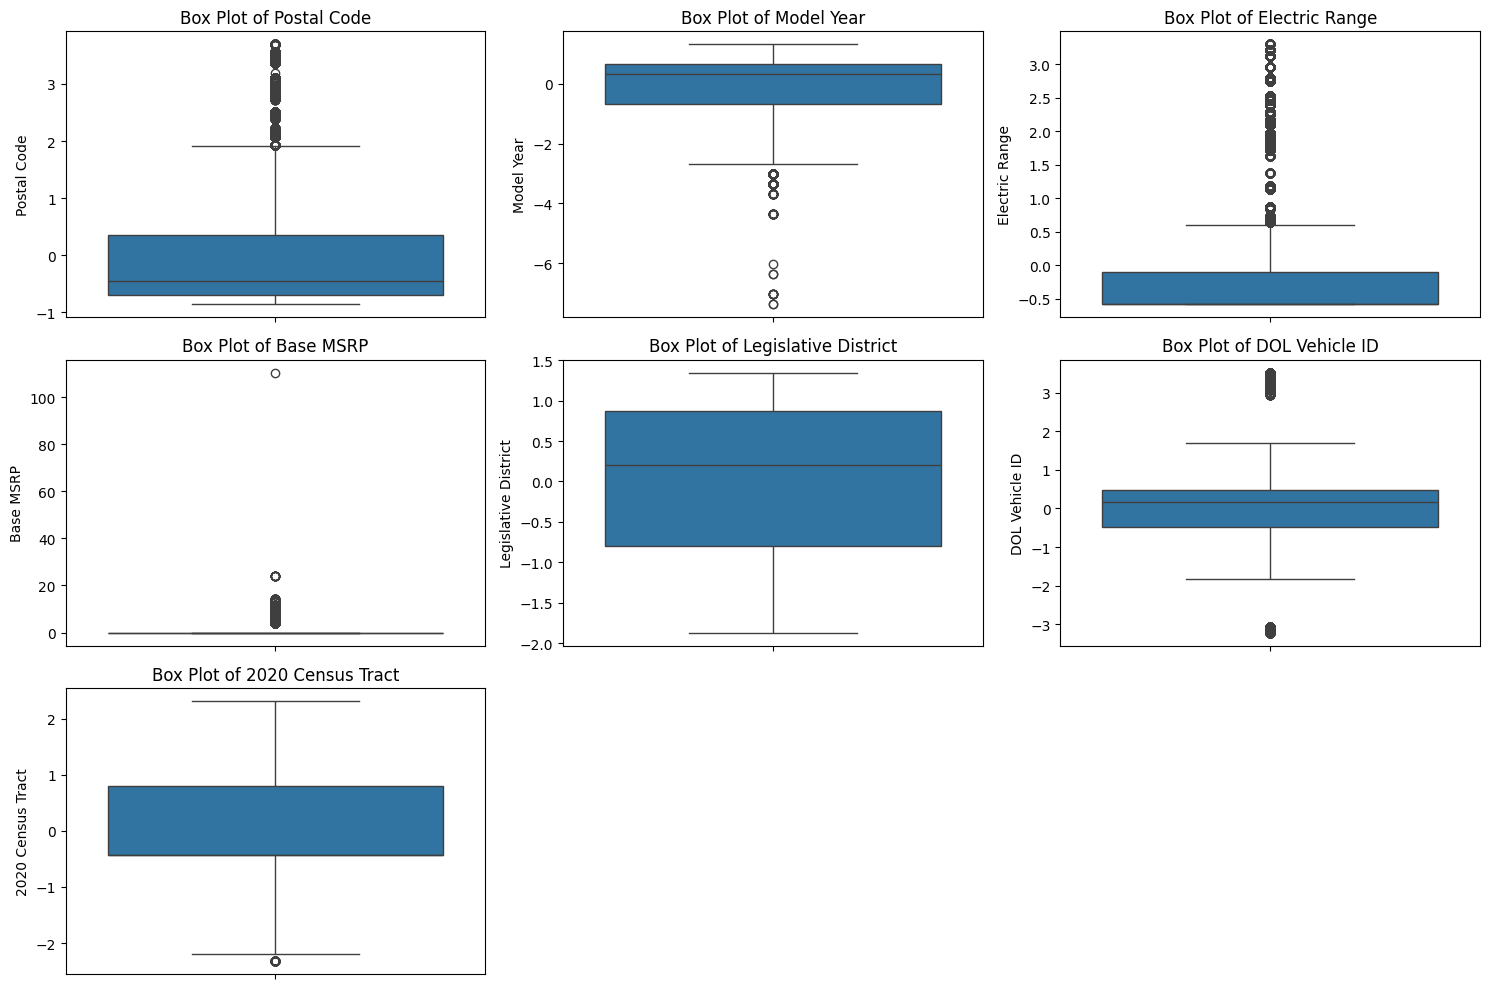

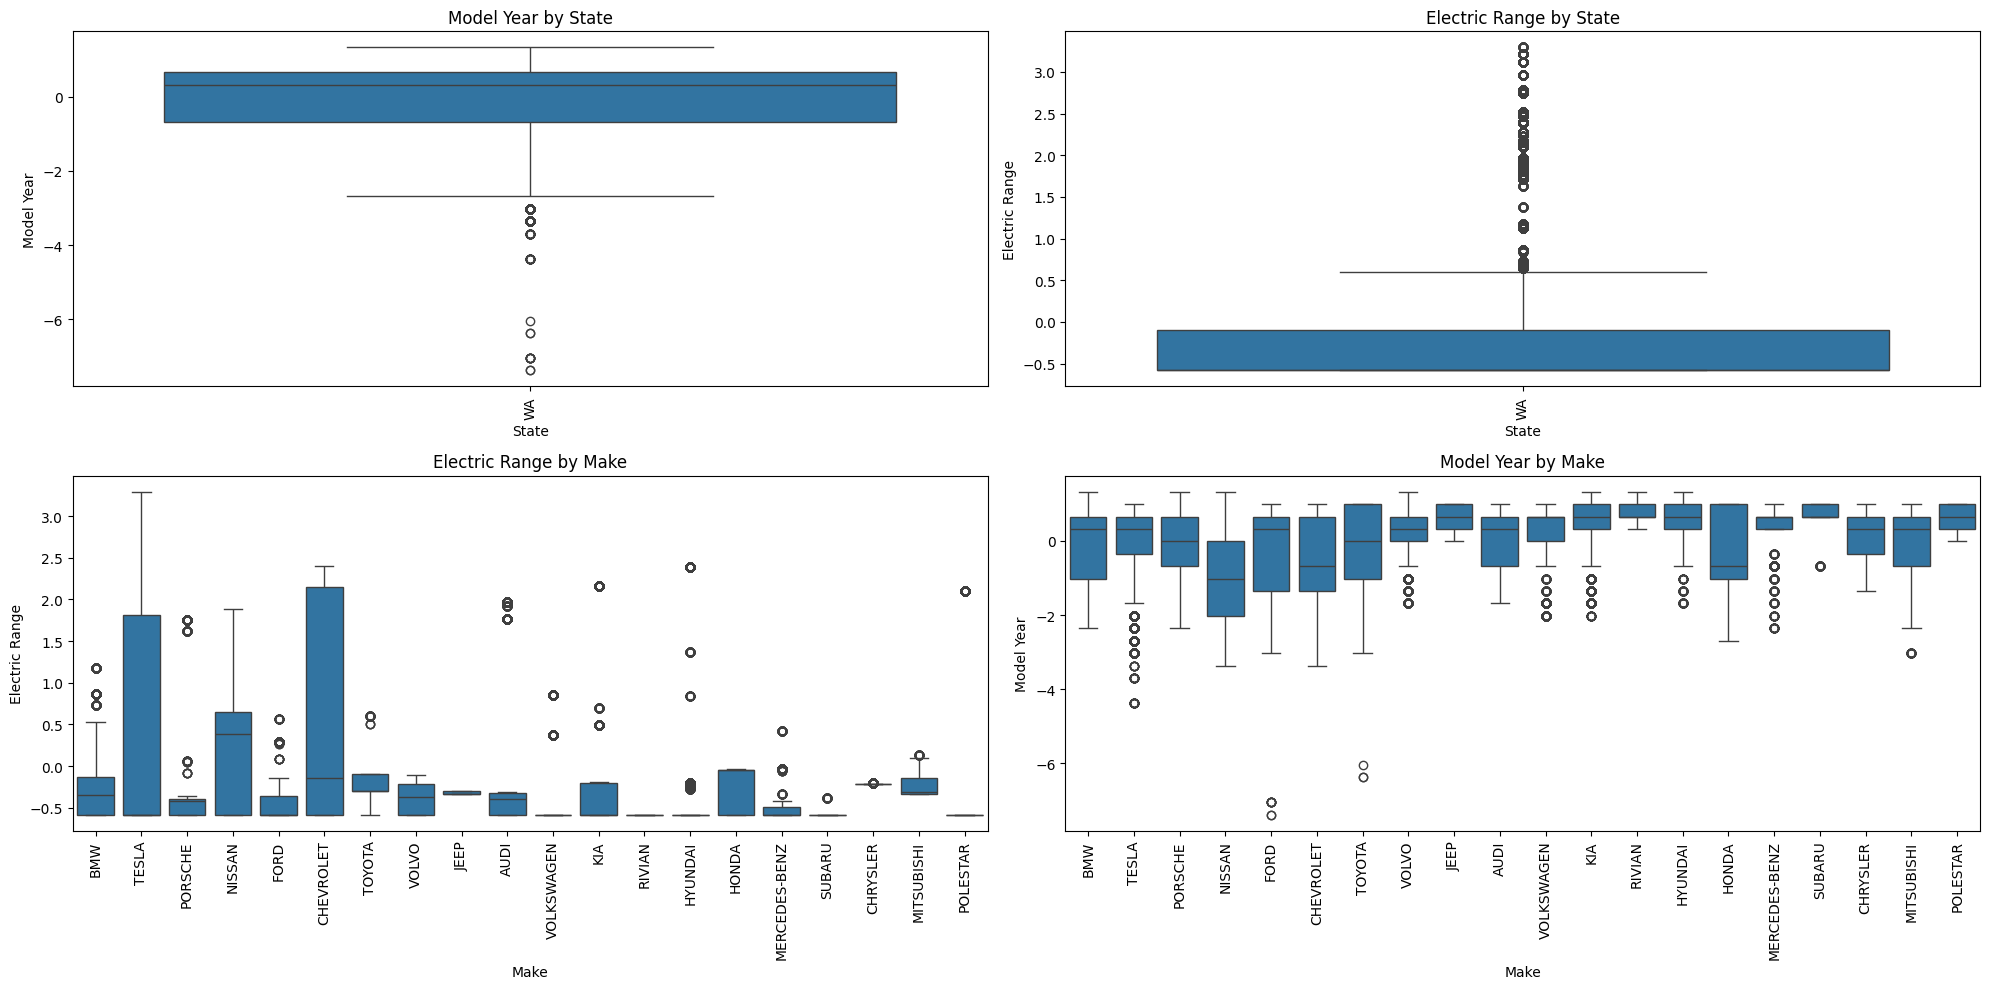

In [ ]:
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

numerical_columns1 = numerical_columns_dropped
# Create histograms for each numeric feature
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_columns):
    plt.subplot(3, 3, i + 1)  
    sns.histplot(df_dropped[feature], bins=30, kde=True) 
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

limited_numerical_columns = numerical_columns[:5] 

# Create scatter plots for each pair of numeric features
plt.figure(figsize=(15, 15))
num_features = len(limited_numerical_columns)

for index, (feature1, feature2) in enumerate(itertools.combinations(limited_numerical_columns, 2)):
    plt.subplot(num_features, num_features, index + 1)  
    sns.scatterplot(data=df_dropped, x=feature1, y=feature2)
    plt.title(f'{feature1} vs {feature2} (Z-Score Normalized)')
    plt.xlabel(feature1)
    plt.ylabel(feature2)

plt.tight_layout()
plt.show()

# Create box plots for each numeric feature
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_columns): 
    plt.subplot(3, 3, i + 1)
    sns.boxplot(data=df_dropped, y=feature)
    plt.title(f'Box Plot of {feature}')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

# Additional comparison plots for selected categorical and numerical pairs
selected_pairs = [
    ('State', 'Model Year'),
    ('State', 'Electric Range'),
    ('Make', 'Electric Range'),
    ('Make', 'Model Year')
]

fig, axes = plt.subplots(2, 2, figsize=(20, 10)) 
axes = axes.flatten()  

for plot_index, (cat_feature, num_feature) in enumerate(selected_pairs):
    if cat_feature in df_dropped.columns and num_feature in df_dropped.columns:
        if df_dropped[cat_feature].nunique() > 20:
            df_sampled = df_dropped[df_dropped[cat_feature].isin(df_dropped[cat_feature].value_counts().index[:20])]
        else:
            df_sampled = df_dropped

        sns.boxplot(data=df_sampled, x=cat_feature, y=num_feature, ax=axes[plot_index])
        axes[plot_index].set_xlabel(cat_feature)
        axes[plot_index].set_ylabel(num_feature)
        axes[plot_index].set_title(f'{num_feature} by {cat_feature}')
        axes[plot_index].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


4.2. Comparative Visualization: Compare the distribution of EVs across different locations (cities, counties) using bar charts or stacked bar charts.

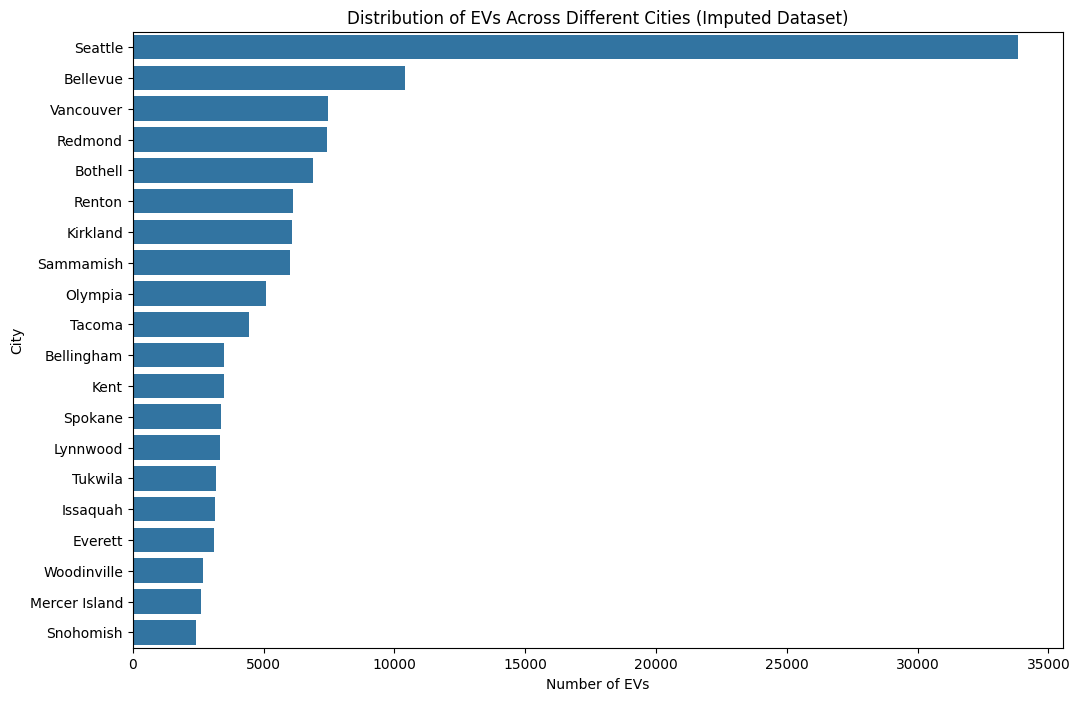

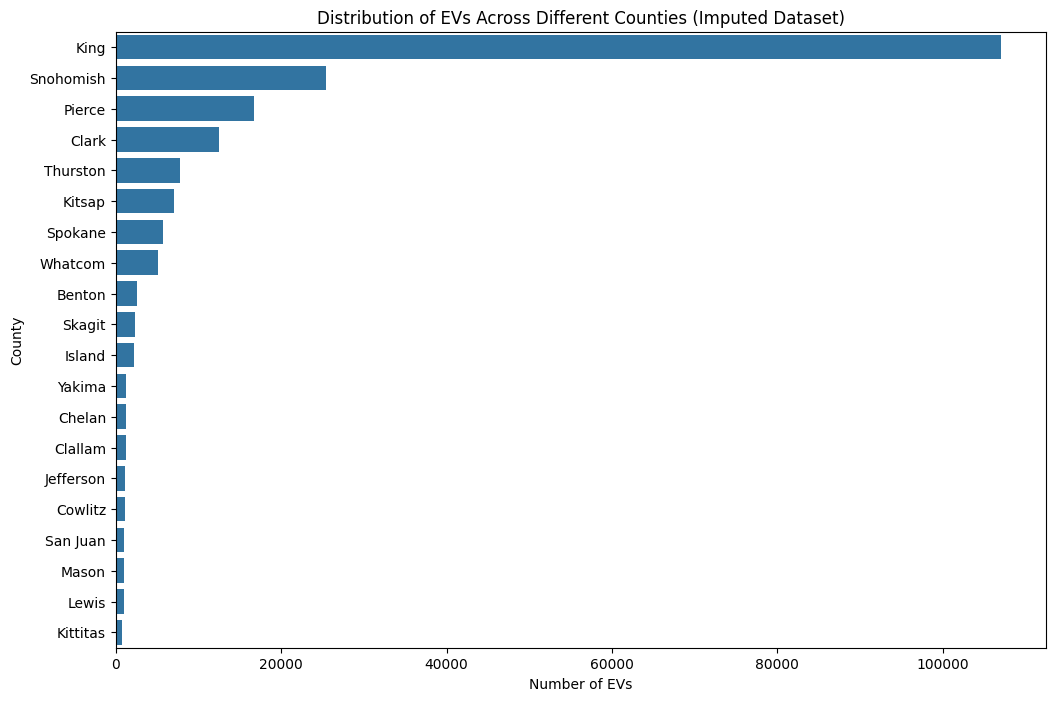

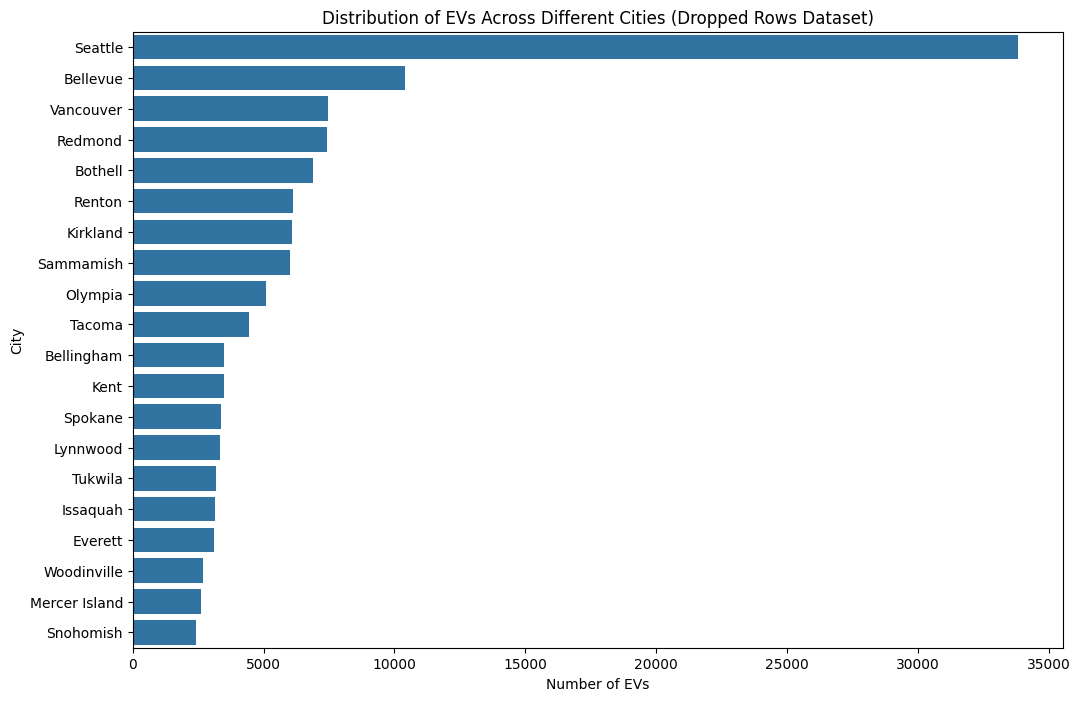

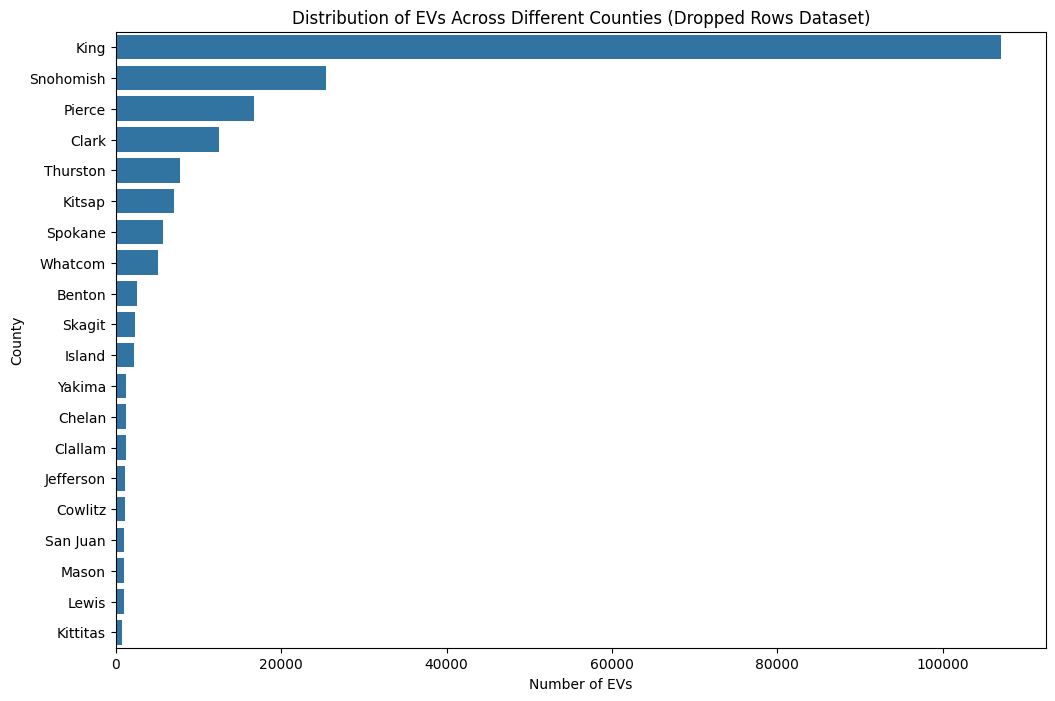

City counts (Imputed Dataset):
             City  Count
0         Seattle  33858
1        Bellevue  10414
2       Vancouver   7475
3         Redmond   7438
4         Bothell   6877
5          Renton   6132
6        Kirkland   6093
7       Sammamish   5995
8         Olympia   5079
9          Tacoma   4454
10     Bellingham   3475
11           Kent   3472
12        Spokane   3367
13       Lynnwood   3332
14        Tukwila   3178
15       Issaquah   3143
16        Everett   3106
17    Woodinville   2691
18  Mercer Island   2622
19      Snohomish   2426

City counts (Dropped Rows Dataset):
             City  Count
0         Seattle  33853
1        Bellevue  10414
2       Vancouver   7475
3         Redmond   7438
4         Bothell   6877
5          Renton   6131
6        Kirkland   6092
7       Sammamish   5995
8         Olympia   5079
9          Tacoma   4454
10     Bellingham   3475
11           Kent   3472
12        Spokane   3367
13       Lynnwood   3332
14        Tukwila   3178
15     

In [20]:

# Strategy 1 (Imputed Dataset)
# Group by city and count the number of EVs
city_counts_imputed = df_imputed_copy['City'].value_counts().reset_index()
city_counts_imputed.columns = ['City', 'Count']

# Plot the bar chart for cities (Imputed Dataset)
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='City', data=city_counts_imputed.head(20))
plt.title('Distribution of EVs Across Different Cities (Imputed Dataset)')
plt.xlabel('Number of EVs')
plt.ylabel('City')
plt.show()

# Group by county and count the number of EVs
county_counts_imputed = df_imputed_copy['County'].value_counts().reset_index()
county_counts_imputed.columns = ['County', 'Count']

# Plot the bar chart for counties (Imputed Dataset)
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='County', data=county_counts_imputed.head(20))
plt.title('Distribution of EVs Across Different Counties (Imputed Dataset)')
plt.xlabel('Number of EVs')
plt.ylabel('County')
plt.show()

# Strategy 2 (Dropped Rows Dataset)
# Group by city and count the number of EVs
city_counts_dropped = df_dropped_copy['City'].value_counts().reset_index()
city_counts_dropped.columns = ['City', 'Count']

# Plot the bar chart for cities (Dropped Rows Dataset)
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='City', data=city_counts_dropped.head(20))
plt.title('Distribution of EVs Across Different Cities (Dropped Rows Dataset)')
plt.xlabel('Number of EVs')
plt.ylabel('City')
plt.show()

# Group by county and count the number of EVs
county_counts_dropped = df_dropped_copy['County'].value_counts().reset_index()
county_counts_dropped.columns = ['County', 'Count']

# Plot the bar chart for counties (Dropped Rows Dataset)
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='County', data=county_counts_dropped.head(20))
plt.title('Distribution of EVs Across Different Counties (Dropped Rows Dataset)')
plt.xlabel('Number of EVs')
plt.ylabel('County')
plt.show()


# Display the counts of EVs by city in the imputed dataset
print("City counts (Imputed Dataset):")
print(city_counts_imputed.head(20)) 

# Display the counts of EVs by city in the dropped dataset
print("\nCity counts (Dropped Rows Dataset):")
print(city_counts_dropped.head(20))  

# Display the counts of EVs by county in the imputed dataset
print("\nCounty counts (Imputed Dataset):")
print(county_counts_imputed.head(20))  

# Display the counts of EVs by county in the dropped dataset
print("\nCounty counts (Dropped Rows Dataset):")
print(county_counts_dropped.head(20))  


Additional Analysis

11. Temporal Analysis (Optional): If the dataset includes data across multiple time points, analyze the temporal trends in EV adoption rates and model popularity.

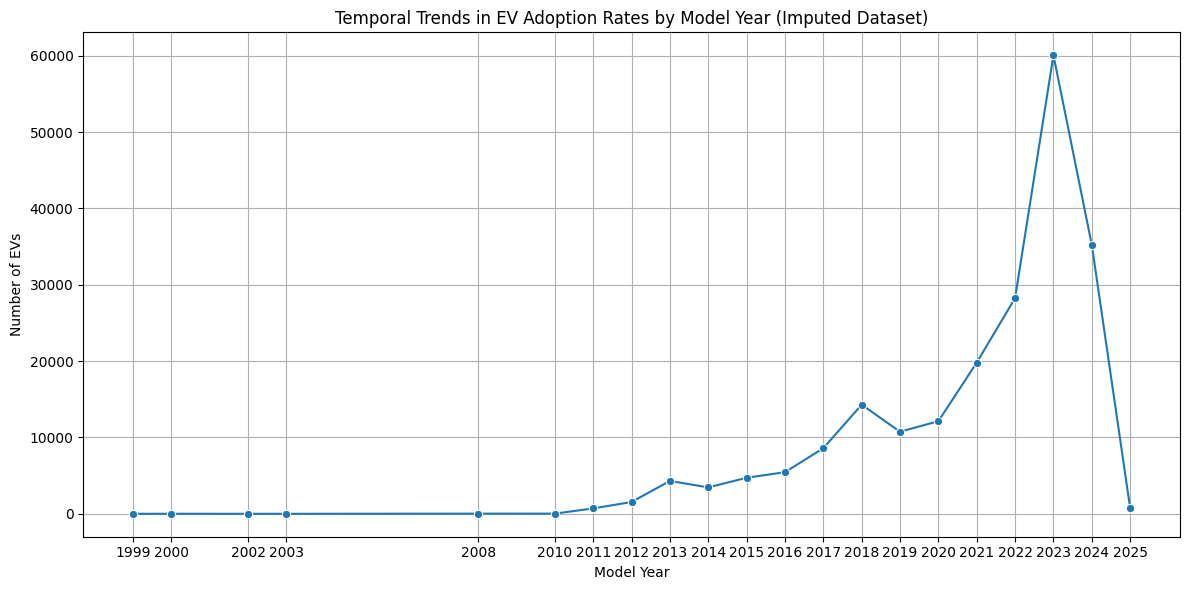

<Figure size 1200x800 with 0 Axes>

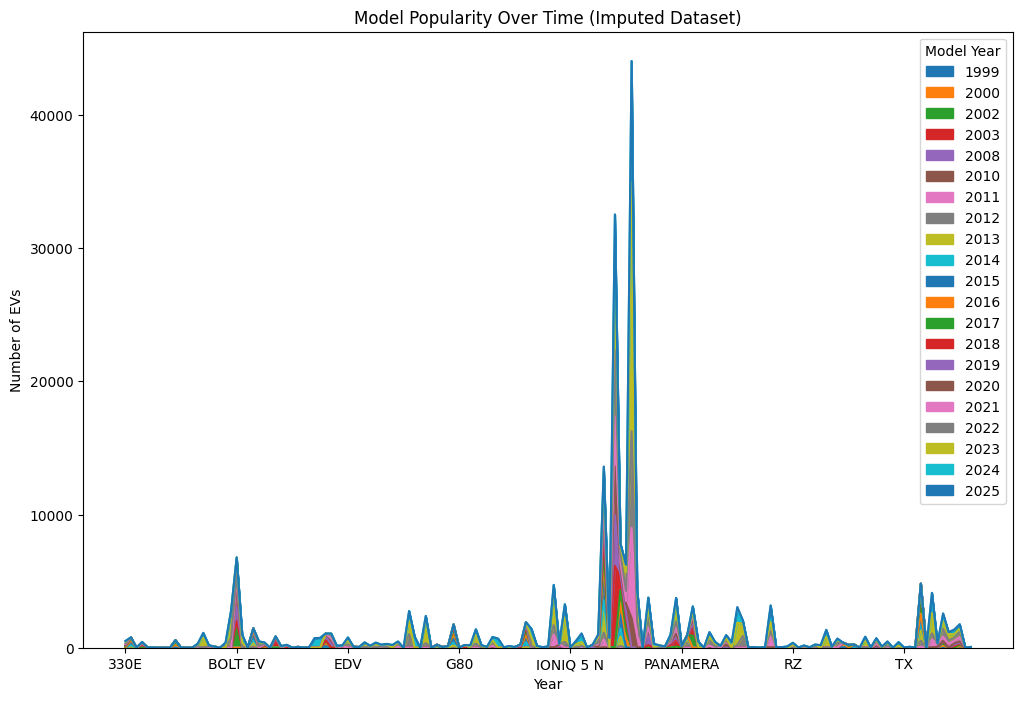

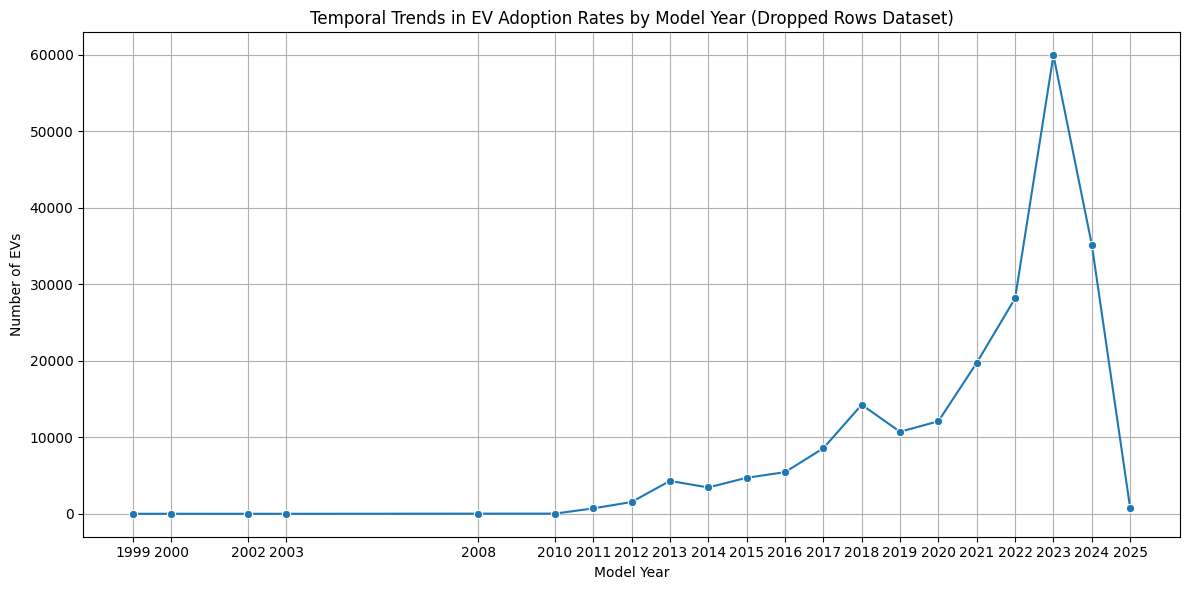

<Figure size 1200x800 with 0 Axes>

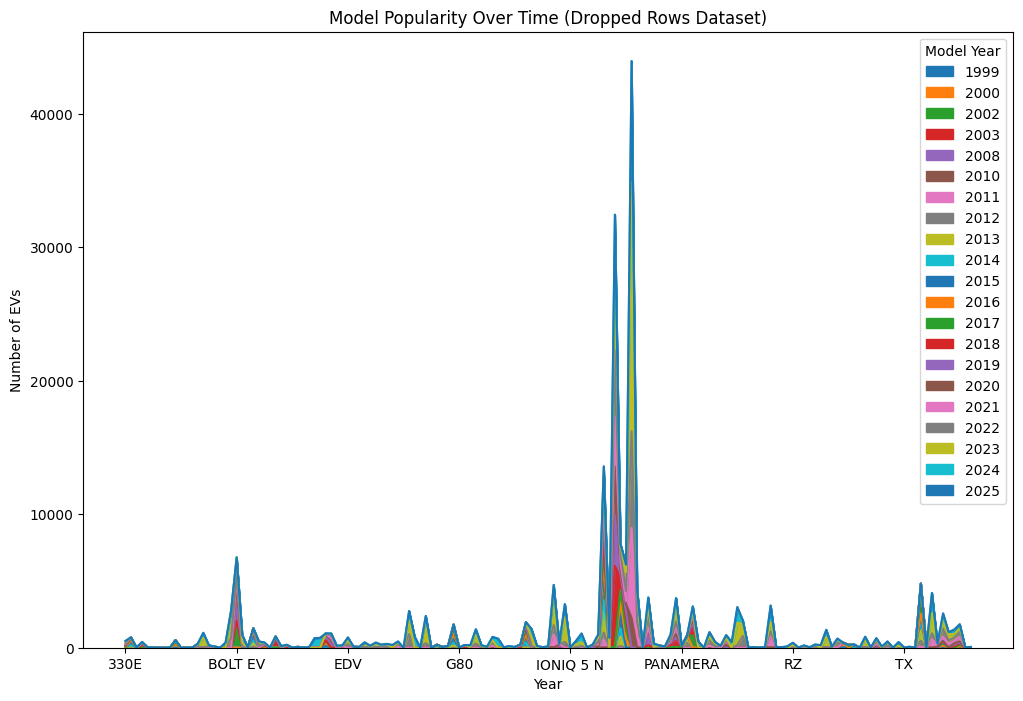

In [21]:
# Temporal Analysis for Imputed Dataset
# Aggregate data by Model Year
adoption_rates_imputed = df_imputed_copy['Model Year'].value_counts().sort_index()

# Plot adoption rates over the years (Imputed Dataset)
plt.figure(figsize=(12, 6))
sns.lineplot(x=adoption_rates_imputed.index, y=adoption_rates_imputed.values, marker='o')
plt.title('Temporal Trends in EV Adoption Rates by Model Year (Imputed Dataset)')
plt.xlabel('Model Year')
plt.ylabel('Number of EVs')
plt.xticks(adoption_rates_imputed.index)
plt.grid()
plt.tight_layout()
plt.show()

# Model popularity over time (Imputed Dataset)
model_popularity_imputed = df_imputed_copy.groupby(['Model Year', 'Model']).size().unstack().fillna(0)

# Plotting model popularity over time (Imputed Dataset)
plt.figure(figsize=(12, 8))
model_popularity_imputed.T.plot(kind='area', stacked=True, figsize=(12, 8))
plt.title('Model Popularity Over Time (Imputed Dataset)')
plt.xlabel('Year')
plt.ylabel('Number of EVs')
plt.show()

# Temporal Analysis for Dropped Rows Dataset
# Aggregate data by Model Year
adoption_rates_dropped = df_dropped_copy['Model Year'].value_counts().sort_index()

# Plot adoption rates over the years (Dropped Rows Dataset)
plt.figure(figsize=(12, 6))
sns.lineplot(x=adoption_rates_dropped.index, y=adoption_rates_dropped.values, marker='o')
plt.title('Temporal Trends in EV Adoption Rates by Model Year (Dropped Rows Dataset)')
plt.xlabel('Model Year')
plt.ylabel('Number of EVs')
plt.xticks(adoption_rates_dropped.index)
plt.grid()
plt.tight_layout()
plt.show()

# Model popularity over time (Dropped Rows Dataset)
model_popularity_dropped = df_dropped_copy.groupby(['Model Year', 'Model']).size().unstack().fillna(0)

# Plotting model popularity over time (Dropped Rows Dataset)
plt.figure(figsize=(12, 8))
model_popularity_dropped.T.plot(kind='area', stacked=True, figsize=(12, 8))
plt.title('Model Popularity Over Time (Dropped Rows Dataset)')
plt.xlabel('Year')
plt.ylabel('Number of EVs')
plt.show()
